# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
import os

# data path
data_dir = 'processed_celeba_small/'

# unzip the dataset if required
if os.path.exists('processed_celeba_small.zip') and not os.path.exists(data_dir):
    !unzip processed_celeba_small.zip

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets, transforms

# random seed PyTorch
torch.manual_seed(42)

In [3]:
def get_dataloader(batch_size, img_size, data_dir=data_dir):
    """
    Generate a data loader with batched image data
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: The directory where image data is located; default: data_dir global variable
    :return: The data loader with batched image data
    """

    # define the image processing pipeline
    processing_pipeline = transforms.Compose([transforms.Resize(img_size),
                                             transforms.RandomHorizontalFlip(0.5),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])

    # create the dataset
    dataset = datasets.ImageFolder(data_dir, transform=processing_pipeline)

    # define the batch size
    if len(dataset) > batch_size:
        batch_size = batch_size

    else:
        batch_size = len(dataset)

    # create the data loader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # return the data loader
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# define data loader hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

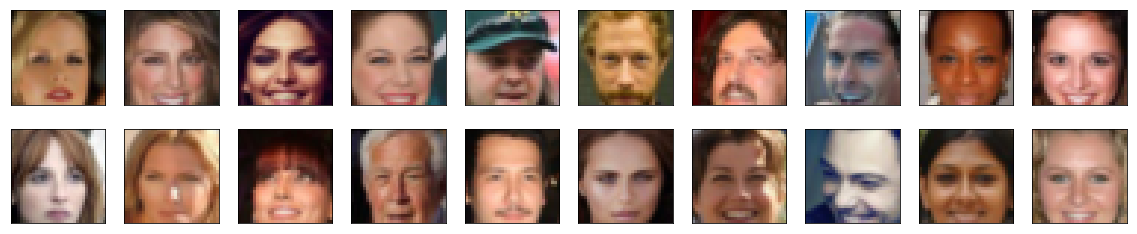

In [5]:
# helper display function
def imshow(img):
    """
    Display an image using Matplotlib
    :param img: The image to display
    """

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
def scale(img, scale_range=(-1, 1)):
    """
    Scale the pixel values of an image from (0, 1) to a given range
    :param img: The image to scale
    :param scale_range: The scale min and max values; default: (-1, 1)
    :return: The scaled image
    """

    # define the range boundaries
    range_min, range_max = scale_range

    # scale the image with the range boundaries
    img *= range_max - range_min
    img += range_min

    return img

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.6314)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Create a module sequence with a convolution layer and (optionally) a batch normalization layer
    :param in_channels: The number of input channels
    :param out_channels: The number of output channels
    :param kernel_size: The size of the convolving kernel
    :param stride: The stride of the convolution; default: 2
    :param padding: The zero-padding added to both sides of the input; default: 1
    :param batch_norm: Includes batch normalization if enabled; default: True
    :return: The container of the module sequence
    """

    # define module sequence
    layers = []

    # append convolutional layer
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))

    # append batch normalization layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    # return the sequence container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the discriminator neural network
        :param conv_dim: The depth of the first convolutional layer
        """

        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        self.conv1 = conv(3, self.conv_dim, 4, batch_norm=False)
        self.conv2 = conv(self.conv_dim, self.conv_dim*2, 4, batch_norm=True)
        self.conv3 = conv(self.conv_dim*2, self.conv_dim*4, 4, batch_norm=True)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(self.conv_dim*4 * 4 * 4, 1)

    def forward(self, x):
        """
        Forward propagation of the discriminator neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """

        x = F.leaky_relu(self.conv1(x), negative_slope=0.02)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.02)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.02)
        x = self.dropout(x)
        x = self.fc1(x.view(-1, self.conv_dim*4 * 4 * 4))

        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Create a module sequence with a transposed convolution layer and (optionally) a batch normalization layer
    :param in_channels: The number of input channels
    :param out_channels: The number of output channels
    :param kernel_size: The size of the convolving kernel
    :param stride: The stride of the convolution; default: 2
    :param padding: The zero-padding added to both sides of the input; default: 1
    :param batch_norm: Includes batch normalization if enabled; default: True
    :return: The container of the module sequence
    """

    # define module sequence
    layers = []

    # append transposed convolutional layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))

    # append batch normalization layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    # return the sequence container
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the generator neural network
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """

        super(Generator, self).__init__()

        self.z_size = z_size
        self.conv_dim = conv_dim
        self.fc1 = nn.Linear(self.z_size, self.conv_dim*4*4*4)
        self.tran1 = deconv(self.conv_dim*4, self.conv_dim*2, 4, batch_norm=True)
        self.tran2 = deconv(self.conv_dim*2, self.conv_dim, 4, batch_norm=True)
        self.tran3 = deconv(self.conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the generator neural network
        :param x: The input to the neural network
        :return: A 32x32x3 Tensor image as output
        """

        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = F.relu(self.tran1(x))
        x = F.relu(self.tran2(x))
        x = torch.tanh(self.tran3(x))

        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Initialize module weights with values from a normal distribution N(0, 0.02) and biases with zeros
    :param m: The module to initialize
    """

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc
    classname = m.__class__.__name__

    # initialize weights of convolutional and fully connected layers
    if 'Conv' in classname or 'Linear' in classname:
        m.weight.data.normal_(0.0, 0.02)

    # initialize weights and biases of batch normalization layers
    elif 'BatchNorm' in classname:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):

    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G

#### Exercise: Define model hyperparameters

In [15]:
# define model hyperparameters
d_conv_dim = 32
g_conv_dim = 64
z_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.25)
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=64, out_features=4096, bias=True)
  (tran1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tran2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# check for a GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, smooth=True, train_on_gpu=False):
    """
    Calculate how close discriminator outputs are to being real
    :param D_out: The discriminator logits
    :param smooth: Smooth the labels if enabled; default: True
    :param train_on_gpu: Use CUDA optimization if enabled; default: False
    :return: The real loss
    """

    batch_size = D_out.size(0)

    # smooth, real labels = 0.9
    if smooth:
        labels = torch.ones(batch_size)*0.9

    # real labels = 1
    else:
        labels = torch.ones(batch_size)

    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()

    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()

    # calculate loss
    loss = criterion(D_out.squeeze(), labels)

    return loss

In [18]:
def fake_loss(D_out, train_on_gpu=False):
    """
    Calculate how close discriminator outputs are to being fake
    :param D_out: The discriminator logits
    :param train_on_gpu: Use CUDA optimization if enabled; default: False
    :return: The fake loss
    """

    batch_size = D_out.size(0)

    # fake labels = 0
    labels = torch.zeros(batch_size)

    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()

    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()

    # calculate loss
    loss = criterion(D_out.squeeze(), labels)

    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# define optimizer hyperparameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def generate_random_images(batch_size, z_size, train_on_gpu=False):
    """
    Generates a batch of random images
    :param batch_size: The number of random images
    :param z_size: The square size of the random images
    :param train_on_gpu: Use CUDA optimization if enabled; default: False
    :return: The random images
    """

    # generate random images
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()

    # move random images to GPU if available
    if train_on_gpu:
        z = z.cuda()

    return z

In [21]:
def train(D, G, n_epochs, print_every=100, train_on_gpu=False):
    """
    Train adversarial networks for some number of epochs
    :param D: The discriminator neural network
    :param G: The generator neural network
    :param n_epochs: The number of epochs to train for
    :param print_every: When to print and record the neural networks' losses; default: 100
    :param train_on_gpu: Uses CUDA optimization if enabled; default: False
    :return: D and G losses
    """

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    z_size = G.z_size
    fixed_z = generate_random_images(16, z_size, train_on_gpu)

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            if train_on_gpu:
                real_images = real_images.cuda()

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images

            # clear accumulated gradients
            d_optimizer.zero_grad()

            # compute the discriminator losses on real images
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, True, train_on_gpu)

            # generate fake images
            z = generate_random_images(batch_size, z_size, train_on_gpu)
            fake_images = G(z)

            # compute the discriminator losses on fake images
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake, train_on_gpu)

            # compute the discriminator total loss
            d_loss = d_real_loss + d_fake_loss

            # backpropagate the discriminator total loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss

            # clear accumulated gradients
            g_optimizer.zero_grad()

            # generate fake images
            z = generate_random_images(batch_size, z_size, train_on_gpu)
            fake_images = G(z)

            # compute the generator loss
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake, True, train_on_gpu)

            # backpropagate the generator loss
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                message = 'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'
                print(message.format(epoch + 1, n_epochs, d_loss.item(), g_loss.item()))

        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval()  # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs
n_epochs = 1000

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, train_on_gpu=train_on_gpu)

Epoch [    1/ 1000] | d_loss: 1.5099 | g_loss: 1.0346
Epoch [    1/ 1000] | d_loss: 0.7565 | g_loss: 2.5988
Epoch [    1/ 1000] | d_loss: 0.5799 | g_loss: 3.0322
Epoch [    1/ 1000] | d_loss: 0.4989 | g_loss: 3.7100
Epoch [    1/ 1000] | d_loss: 0.4191 | g_loss: 4.0896
Epoch [    1/ 1000] | d_loss: 0.4685 | g_loss: 3.4125
Epoch [    1/ 1000] | d_loss: 0.6118 | g_loss: 3.1492
Epoch [    1/ 1000] | d_loss: 0.7137 | g_loss: 2.1299
Epoch [    1/ 1000] | d_loss: 0.7361 | g_loss: 2.5615
Epoch [    1/ 1000] | d_loss: 1.2526 | g_loss: 1.3859
Epoch [    1/ 1000] | d_loss: 0.9423 | g_loss: 1.9997
Epoch [    1/ 1000] | d_loss: 1.0018 | g_loss: 2.0747
Epoch [    1/ 1000] | d_loss: 1.2115 | g_loss: 1.9253
Epoch [    1/ 1000] | d_loss: 1.0690 | g_loss: 1.4371
Epoch [    1/ 1000] | d_loss: 1.1669 | g_loss: 1.2636
Epoch [    2/ 1000] | d_loss: 1.2253 | g_loss: 1.9662
Epoch [    2/ 1000] | d_loss: 1.1550 | g_loss: 1.3723
Epoch [    2/ 1000] | d_loss: 1.4131 | g_loss: 1.1498
Epoch [    2/ 1000] | d_loss

Epoch [   11/ 1000] | d_loss: 1.3946 | g_loss: 0.9867
Epoch [   11/ 1000] | d_loss: 1.3409 | g_loss: 1.0067
Epoch [   11/ 1000] | d_loss: 1.2239 | g_loss: 1.0460
Epoch [   11/ 1000] | d_loss: 1.3261 | g_loss: 1.0294
Epoch [   11/ 1000] | d_loss: 1.0944 | g_loss: 0.8439
Epoch [   11/ 1000] | d_loss: 1.3641 | g_loss: 0.9217
Epoch [   11/ 1000] | d_loss: 1.2529 | g_loss: 1.0165
Epoch [   11/ 1000] | d_loss: 1.2646 | g_loss: 1.0692
Epoch [   11/ 1000] | d_loss: 1.2690 | g_loss: 0.9941
Epoch [   11/ 1000] | d_loss: 1.2345 | g_loss: 1.1666
Epoch [   11/ 1000] | d_loss: 1.1597 | g_loss: 0.9424
Epoch [   11/ 1000] | d_loss: 1.2284 | g_loss: 1.0890
Epoch [   11/ 1000] | d_loss: 1.2124 | g_loss: 1.1596
Epoch [   11/ 1000] | d_loss: 1.2389 | g_loss: 1.0568
Epoch [   12/ 1000] | d_loss: 1.2190 | g_loss: 0.9912
Epoch [   12/ 1000] | d_loss: 1.3126 | g_loss: 1.0367
Epoch [   12/ 1000] | d_loss: 1.2758 | g_loss: 0.9630
Epoch [   12/ 1000] | d_loss: 1.3173 | g_loss: 0.9403
Epoch [   12/ 1000] | d_loss

Epoch [   21/ 1000] | d_loss: 1.1139 | g_loss: 1.1396
Epoch [   21/ 1000] | d_loss: 1.1217 | g_loss: 0.9266
Epoch [   21/ 1000] | d_loss: 1.3578 | g_loss: 1.3132
Epoch [   21/ 1000] | d_loss: 1.3978 | g_loss: 1.0724
Epoch [   21/ 1000] | d_loss: 1.1175 | g_loss: 1.0449
Epoch [   21/ 1000] | d_loss: 1.1058 | g_loss: 1.2228
Epoch [   21/ 1000] | d_loss: 1.1541 | g_loss: 1.0499
Epoch [   21/ 1000] | d_loss: 1.0986 | g_loss: 1.1028
Epoch [   21/ 1000] | d_loss: 1.0152 | g_loss: 1.3319
Epoch [   21/ 1000] | d_loss: 1.2063 | g_loss: 1.0589
Epoch [   21/ 1000] | d_loss: 1.3725 | g_loss: 1.1288
Epoch [   21/ 1000] | d_loss: 1.1772 | g_loss: 1.1332
Epoch [   21/ 1000] | d_loss: 1.1281 | g_loss: 0.9060
Epoch [   22/ 1000] | d_loss: 1.1452 | g_loss: 1.3833
Epoch [   22/ 1000] | d_loss: 1.1800 | g_loss: 1.1776
Epoch [   22/ 1000] | d_loss: 1.1473 | g_loss: 0.9362
Epoch [   22/ 1000] | d_loss: 1.2877 | g_loss: 0.8954
Epoch [   22/ 1000] | d_loss: 1.1101 | g_loss: 1.1432
Epoch [   22/ 1000] | d_loss

Epoch [   31/ 1000] | d_loss: 0.9279 | g_loss: 1.3351
Epoch [   31/ 1000] | d_loss: 1.1777 | g_loss: 1.1789
Epoch [   31/ 1000] | d_loss: 1.1922 | g_loss: 1.0664
Epoch [   31/ 1000] | d_loss: 1.1696 | g_loss: 1.0098
Epoch [   31/ 1000] | d_loss: 1.2907 | g_loss: 1.2209
Epoch [   31/ 1000] | d_loss: 1.2747 | g_loss: 0.9054
Epoch [   31/ 1000] | d_loss: 1.1808 | g_loss: 1.1345
Epoch [   31/ 1000] | d_loss: 1.3241 | g_loss: 1.3339
Epoch [   31/ 1000] | d_loss: 0.9979 | g_loss: 1.1080
Epoch [   31/ 1000] | d_loss: 0.9702 | g_loss: 1.0576
Epoch [   31/ 1000] | d_loss: 1.3279 | g_loss: 1.2748
Epoch [   31/ 1000] | d_loss: 1.0760 | g_loss: 0.9380
Epoch [   32/ 1000] | d_loss: 1.1647 | g_loss: 1.1917
Epoch [   32/ 1000] | d_loss: 1.0420 | g_loss: 1.2225
Epoch [   32/ 1000] | d_loss: 1.0823 | g_loss: 1.2154
Epoch [   32/ 1000] | d_loss: 1.2271 | g_loss: 1.1580
Epoch [   32/ 1000] | d_loss: 1.2018 | g_loss: 1.0875
Epoch [   32/ 1000] | d_loss: 1.2678 | g_loss: 0.9500
Epoch [   32/ 1000] | d_loss

Epoch [   41/ 1000] | d_loss: 1.3105 | g_loss: 1.3882
Epoch [   41/ 1000] | d_loss: 1.0087 | g_loss: 1.1948
Epoch [   41/ 1000] | d_loss: 1.1337 | g_loss: 1.0005
Epoch [   41/ 1000] | d_loss: 1.2336 | g_loss: 1.2690
Epoch [   41/ 1000] | d_loss: 1.0949 | g_loss: 1.2077
Epoch [   41/ 1000] | d_loss: 1.2742 | g_loss: 1.3106
Epoch [   41/ 1000] | d_loss: 1.2479 | g_loss: 1.3728
Epoch [   41/ 1000] | d_loss: 1.1620 | g_loss: 1.2974
Epoch [   41/ 1000] | d_loss: 1.2397 | g_loss: 1.1432
Epoch [   41/ 1000] | d_loss: 1.3234 | g_loss: 1.1964
Epoch [   41/ 1000] | d_loss: 1.2922 | g_loss: 1.2867
Epoch [   42/ 1000] | d_loss: 1.1758 | g_loss: 1.0395
Epoch [   42/ 1000] | d_loss: 1.0900 | g_loss: 1.0740
Epoch [   42/ 1000] | d_loss: 1.0213 | g_loss: 1.3235
Epoch [   42/ 1000] | d_loss: 1.2279 | g_loss: 1.2225
Epoch [   42/ 1000] | d_loss: 0.9794 | g_loss: 1.4139
Epoch [   42/ 1000] | d_loss: 1.2354 | g_loss: 1.3557
Epoch [   42/ 1000] | d_loss: 1.2485 | g_loss: 1.0205
Epoch [   42/ 1000] | d_loss

Epoch [   51/ 1000] | d_loss: 1.0883 | g_loss: 1.5116
Epoch [   51/ 1000] | d_loss: 1.2679 | g_loss: 1.2251
Epoch [   51/ 1000] | d_loss: 1.1485 | g_loss: 1.5126
Epoch [   51/ 1000] | d_loss: 0.9649 | g_loss: 1.0057
Epoch [   51/ 1000] | d_loss: 1.3461 | g_loss: 0.9944
Epoch [   51/ 1000] | d_loss: 1.1565 | g_loss: 1.2931
Epoch [   51/ 1000] | d_loss: 1.1717 | g_loss: 1.0753
Epoch [   51/ 1000] | d_loss: 1.0973 | g_loss: 1.2004
Epoch [   51/ 1000] | d_loss: 1.4432 | g_loss: 1.0758
Epoch [   51/ 1000] | d_loss: 1.0789 | g_loss: 1.4164
Epoch [   52/ 1000] | d_loss: 1.4172 | g_loss: 1.6180
Epoch [   52/ 1000] | d_loss: 0.8638 | g_loss: 1.1879
Epoch [   52/ 1000] | d_loss: 1.1233 | g_loss: 1.1326
Epoch [   52/ 1000] | d_loss: 1.0879 | g_loss: 1.7944
Epoch [   52/ 1000] | d_loss: 1.3599 | g_loss: 1.3004
Epoch [   52/ 1000] | d_loss: 1.2518 | g_loss: 1.1984
Epoch [   52/ 1000] | d_loss: 1.3586 | g_loss: 1.1964
Epoch [   52/ 1000] | d_loss: 1.2507 | g_loss: 1.0461
Epoch [   52/ 1000] | d_loss

Epoch [   61/ 1000] | d_loss: 0.9285 | g_loss: 1.5345
Epoch [   61/ 1000] | d_loss: 1.1395 | g_loss: 1.2663
Epoch [   61/ 1000] | d_loss: 1.2014 | g_loss: 1.4795
Epoch [   61/ 1000] | d_loss: 0.9350 | g_loss: 1.3767
Epoch [   61/ 1000] | d_loss: 1.0599 | g_loss: 1.1432
Epoch [   61/ 1000] | d_loss: 1.3656 | g_loss: 1.3088
Epoch [   61/ 1000] | d_loss: 1.1060 | g_loss: 1.2621
Epoch [   61/ 1000] | d_loss: 1.4596 | g_loss: 1.5315
Epoch [   61/ 1000] | d_loss: 0.9382 | g_loss: 1.3416
Epoch [   62/ 1000] | d_loss: 1.3007 | g_loss: 1.0188
Epoch [   62/ 1000] | d_loss: 1.1004 | g_loss: 1.5212
Epoch [   62/ 1000] | d_loss: 1.0205 | g_loss: 1.3040
Epoch [   62/ 1000] | d_loss: 1.1431 | g_loss: 1.6831
Epoch [   62/ 1000] | d_loss: 1.1404 | g_loss: 1.3358
Epoch [   62/ 1000] | d_loss: 1.2334 | g_loss: 0.8861
Epoch [   62/ 1000] | d_loss: 0.9164 | g_loss: 1.4501
Epoch [   62/ 1000] | d_loss: 1.3541 | g_loss: 1.0387
Epoch [   62/ 1000] | d_loss: 1.0705 | g_loss: 1.1358
Epoch [   62/ 1000] | d_loss

Epoch [   71/ 1000] | d_loss: 1.3720 | g_loss: 1.2763
Epoch [   71/ 1000] | d_loss: 1.0277 | g_loss: 1.7677
Epoch [   71/ 1000] | d_loss: 0.9500 | g_loss: 1.7144
Epoch [   71/ 1000] | d_loss: 1.0356 | g_loss: 1.1794
Epoch [   71/ 1000] | d_loss: 1.1710 | g_loss: 1.4384
Epoch [   71/ 1000] | d_loss: 1.2951 | g_loss: 1.3717
Epoch [   71/ 1000] | d_loss: 1.1485 | g_loss: 1.3051
Epoch [   71/ 1000] | d_loss: 1.3393 | g_loss: 1.2443
Epoch [   72/ 1000] | d_loss: 1.0140 | g_loss: 1.4655
Epoch [   72/ 1000] | d_loss: 1.2444 | g_loss: 1.5506
Epoch [   72/ 1000] | d_loss: 1.3234 | g_loss: 1.0023
Epoch [   72/ 1000] | d_loss: 1.0419 | g_loss: 1.3784
Epoch [   72/ 1000] | d_loss: 1.2210 | g_loss: 1.2520
Epoch [   72/ 1000] | d_loss: 1.0552 | g_loss: 1.2905
Epoch [   72/ 1000] | d_loss: 1.0177 | g_loss: 1.4626
Epoch [   72/ 1000] | d_loss: 1.1470 | g_loss: 1.0543
Epoch [   72/ 1000] | d_loss: 1.2275 | g_loss: 1.1100
Epoch [   72/ 1000] | d_loss: 1.1233 | g_loss: 1.6562
Epoch [   72/ 1000] | d_loss

Epoch [   81/ 1000] | d_loss: 1.0482 | g_loss: 1.3813
Epoch [   81/ 1000] | d_loss: 1.2726 | g_loss: 1.1755
Epoch [   81/ 1000] | d_loss: 0.7484 | g_loss: 1.2743
Epoch [   81/ 1000] | d_loss: 1.4775 | g_loss: 1.4439
Epoch [   81/ 1000] | d_loss: 1.1942 | g_loss: 1.2016
Epoch [   81/ 1000] | d_loss: 1.0053 | g_loss: 1.3820
Epoch [   81/ 1000] | d_loss: 1.2322 | g_loss: 1.3078
Epoch [   82/ 1000] | d_loss: 1.3378 | g_loss: 1.4497
Epoch [   82/ 1000] | d_loss: 1.2473 | g_loss: 1.3586
Epoch [   82/ 1000] | d_loss: 0.9691 | g_loss: 1.3004
Epoch [   82/ 1000] | d_loss: 1.3833 | g_loss: 1.2487
Epoch [   82/ 1000] | d_loss: 1.2378 | g_loss: 1.2775
Epoch [   82/ 1000] | d_loss: 1.0812 | g_loss: 1.6661
Epoch [   82/ 1000] | d_loss: 0.9258 | g_loss: 1.4422
Epoch [   82/ 1000] | d_loss: 1.0638 | g_loss: 1.5186
Epoch [   82/ 1000] | d_loss: 0.8814 | g_loss: 1.4083
Epoch [   82/ 1000] | d_loss: 1.0499 | g_loss: 1.3189
Epoch [   82/ 1000] | d_loss: 0.9846 | g_loss: 1.4067
Epoch [   82/ 1000] | d_loss

Epoch [   91/ 1000] | d_loss: 0.8471 | g_loss: 1.9014
Epoch [   91/ 1000] | d_loss: 0.7569 | g_loss: 0.9184
Epoch [   91/ 1000] | d_loss: 1.1514 | g_loss: 1.5209
Epoch [   91/ 1000] | d_loss: 1.1967 | g_loss: 1.3331
Epoch [   91/ 1000] | d_loss: 0.9654 | g_loss: 1.5738
Epoch [   91/ 1000] | d_loss: 1.0826 | g_loss: 1.1136
Epoch [   92/ 1000] | d_loss: 1.3483 | g_loss: 1.1166
Epoch [   92/ 1000] | d_loss: 1.0279 | g_loss: 0.9317
Epoch [   92/ 1000] | d_loss: 1.1582 | g_loss: 1.2880
Epoch [   92/ 1000] | d_loss: 1.1928 | g_loss: 1.3422
Epoch [   92/ 1000] | d_loss: 1.4759 | g_loss: 0.9515
Epoch [   92/ 1000] | d_loss: 1.4324 | g_loss: 1.3258
Epoch [   92/ 1000] | d_loss: 1.1563 | g_loss: 1.1013
Epoch [   92/ 1000] | d_loss: 0.9004 | g_loss: 1.1778
Epoch [   92/ 1000] | d_loss: 1.2168 | g_loss: 1.4160
Epoch [   92/ 1000] | d_loss: 0.9720 | g_loss: 1.3469
Epoch [   92/ 1000] | d_loss: 0.8961 | g_loss: 1.1681
Epoch [   92/ 1000] | d_loss: 1.1542 | g_loss: 1.3174
Epoch [   92/ 1000] | d_loss

Epoch [  101/ 1000] | d_loss: 0.9040 | g_loss: 1.3223
Epoch [  101/ 1000] | d_loss: 0.9880 | g_loss: 1.9490
Epoch [  101/ 1000] | d_loss: 1.0699 | g_loss: 1.2612
Epoch [  101/ 1000] | d_loss: 1.1898 | g_loss: 1.0319
Epoch [  101/ 1000] | d_loss: 0.9755 | g_loss: 1.1616
Epoch [  102/ 1000] | d_loss: 0.9901 | g_loss: 1.3156
Epoch [  102/ 1000] | d_loss: 1.0964 | g_loss: 1.6939
Epoch [  102/ 1000] | d_loss: 1.0065 | g_loss: 1.3018
Epoch [  102/ 1000] | d_loss: 1.2119 | g_loss: 1.4765
Epoch [  102/ 1000] | d_loss: 1.0567 | g_loss: 0.8270
Epoch [  102/ 1000] | d_loss: 0.9099 | g_loss: 1.5093
Epoch [  102/ 1000] | d_loss: 1.2975 | g_loss: 1.4568
Epoch [  102/ 1000] | d_loss: 0.9798 | g_loss: 1.4116
Epoch [  102/ 1000] | d_loss: 1.0344 | g_loss: 1.2144
Epoch [  102/ 1000] | d_loss: 0.9599 | g_loss: 1.1646
Epoch [  102/ 1000] | d_loss: 1.0541 | g_loss: 1.4747
Epoch [  102/ 1000] | d_loss: 0.9482 | g_loss: 1.7205
Epoch [  102/ 1000] | d_loss: 0.9505 | g_loss: 1.5836
Epoch [  102/ 1000] | d_loss

Epoch [  111/ 1000] | d_loss: 1.3471 | g_loss: 1.4900
Epoch [  111/ 1000] | d_loss: 0.9562 | g_loss: 0.7385
Epoch [  111/ 1000] | d_loss: 1.1303 | g_loss: 1.1931
Epoch [  111/ 1000] | d_loss: 1.0454 | g_loss: 1.6985
Epoch [  112/ 1000] | d_loss: 1.1622 | g_loss: 0.9690
Epoch [  112/ 1000] | d_loss: 0.8810 | g_loss: 1.6194
Epoch [  112/ 1000] | d_loss: 1.5221 | g_loss: 1.1840
Epoch [  112/ 1000] | d_loss: 1.0677 | g_loss: 1.0634
Epoch [  112/ 1000] | d_loss: 0.9488 | g_loss: 1.4456
Epoch [  112/ 1000] | d_loss: 0.8315 | g_loss: 1.4092
Epoch [  112/ 1000] | d_loss: 1.3472 | g_loss: 1.2223
Epoch [  112/ 1000] | d_loss: 1.2174 | g_loss: 1.3734
Epoch [  112/ 1000] | d_loss: 0.9759 | g_loss: 1.6744
Epoch [  112/ 1000] | d_loss: 0.7599 | g_loss: 1.4606
Epoch [  112/ 1000] | d_loss: 0.8673 | g_loss: 1.8889
Epoch [  112/ 1000] | d_loss: 1.1693 | g_loss: 1.1259
Epoch [  112/ 1000] | d_loss: 1.1047 | g_loss: 1.2781
Epoch [  112/ 1000] | d_loss: 1.1977 | g_loss: 0.9164
Epoch [  112/ 1000] | d_loss

Epoch [  121/ 1000] | d_loss: 1.3050 | g_loss: 1.1686
Epoch [  121/ 1000] | d_loss: 1.2798 | g_loss: 0.9454
Epoch [  121/ 1000] | d_loss: 0.6947 | g_loss: 1.0847
Epoch [  122/ 1000] | d_loss: 0.9376 | g_loss: 1.0678
Epoch [  122/ 1000] | d_loss: 1.2829 | g_loss: 2.0817
Epoch [  122/ 1000] | d_loss: 1.3151 | g_loss: 0.9500
Epoch [  122/ 1000] | d_loss: 1.2005 | g_loss: 1.5440
Epoch [  122/ 1000] | d_loss: 0.8870 | g_loss: 1.4377
Epoch [  122/ 1000] | d_loss: 1.0687 | g_loss: 1.1715
Epoch [  122/ 1000] | d_loss: 0.9890 | g_loss: 1.6147
Epoch [  122/ 1000] | d_loss: 1.0825 | g_loss: 1.2648
Epoch [  122/ 1000] | d_loss: 1.1637 | g_loss: 1.3038
Epoch [  122/ 1000] | d_loss: 1.2960 | g_loss: 1.2167
Epoch [  122/ 1000] | d_loss: 1.2355 | g_loss: 1.1794
Epoch [  122/ 1000] | d_loss: 1.2977 | g_loss: 1.3974
Epoch [  122/ 1000] | d_loss: 1.2531 | g_loss: 1.7627
Epoch [  122/ 1000] | d_loss: 1.4020 | g_loss: 1.3372
Epoch [  122/ 1000] | d_loss: 1.5062 | g_loss: 1.4568
Epoch [  123/ 1000] | d_loss

Epoch [  131/ 1000] | d_loss: 1.2216 | g_loss: 1.4808
Epoch [  131/ 1000] | d_loss: 1.2782 | g_loss: 1.3794
Epoch [  132/ 1000] | d_loss: 1.0649 | g_loss: 1.4078
Epoch [  132/ 1000] | d_loss: 0.8736 | g_loss: 1.4447
Epoch [  132/ 1000] | d_loss: 1.2070 | g_loss: 1.2161
Epoch [  132/ 1000] | d_loss: 0.9843 | g_loss: 1.5977
Epoch [  132/ 1000] | d_loss: 1.2602 | g_loss: 1.2025
Epoch [  132/ 1000] | d_loss: 0.8849 | g_loss: 1.1460
Epoch [  132/ 1000] | d_loss: 0.7735 | g_loss: 1.0775
Epoch [  132/ 1000] | d_loss: 1.1434 | g_loss: 0.8475
Epoch [  132/ 1000] | d_loss: 0.6606 | g_loss: 1.9634
Epoch [  132/ 1000] | d_loss: 1.3835 | g_loss: 0.8814
Epoch [  132/ 1000] | d_loss: 1.3043 | g_loss: 1.0613
Epoch [  132/ 1000] | d_loss: 0.9045 | g_loss: 1.5010
Epoch [  132/ 1000] | d_loss: 1.0816 | g_loss: 1.0535
Epoch [  132/ 1000] | d_loss: 1.0037 | g_loss: 0.7868
Epoch [  132/ 1000] | d_loss: 1.1383 | g_loss: 0.9414
Epoch [  133/ 1000] | d_loss: 1.3101 | g_loss: 1.4659
Epoch [  133/ 1000] | d_loss

Epoch [  141/ 1000] | d_loss: 1.2171 | g_loss: 0.9342
Epoch [  142/ 1000] | d_loss: 1.0109 | g_loss: 1.4534
Epoch [  142/ 1000] | d_loss: 0.8000 | g_loss: 1.4001
Epoch [  142/ 1000] | d_loss: 1.0131 | g_loss: 1.4535
Epoch [  142/ 1000] | d_loss: 0.8718 | g_loss: 1.4120
Epoch [  142/ 1000] | d_loss: 1.1632 | g_loss: 1.2913
Epoch [  142/ 1000] | d_loss: 0.8700 | g_loss: 1.2870
Epoch [  142/ 1000] | d_loss: 1.0905 | g_loss: 1.6204
Epoch [  142/ 1000] | d_loss: 1.1996 | g_loss: 1.4924
Epoch [  142/ 1000] | d_loss: 1.0210 | g_loss: 0.7421
Epoch [  142/ 1000] | d_loss: 1.5407 | g_loss: 1.8898
Epoch [  142/ 1000] | d_loss: 0.9213 | g_loss: 1.7622
Epoch [  142/ 1000] | d_loss: 0.9561 | g_loss: 1.5866
Epoch [  142/ 1000] | d_loss: 1.0288 | g_loss: 1.5468
Epoch [  142/ 1000] | d_loss: 1.1352 | g_loss: 1.4834
Epoch [  142/ 1000] | d_loss: 0.9966 | g_loss: 0.9521
Epoch [  143/ 1000] | d_loss: 0.9019 | g_loss: 2.0056
Epoch [  143/ 1000] | d_loss: 1.4699 | g_loss: 1.6690
Epoch [  143/ 1000] | d_loss

Epoch [  152/ 1000] | d_loss: 0.8170 | g_loss: 1.4646
Epoch [  152/ 1000] | d_loss: 1.0067 | g_loss: 1.3075
Epoch [  152/ 1000] | d_loss: 1.0995 | g_loss: 1.7431
Epoch [  152/ 1000] | d_loss: 1.0439 | g_loss: 1.1368
Epoch [  152/ 1000] | d_loss: 1.1186 | g_loss: 1.8729
Epoch [  152/ 1000] | d_loss: 1.0247 | g_loss: 1.5277
Epoch [  152/ 1000] | d_loss: 1.1585 | g_loss: 1.3978
Epoch [  152/ 1000] | d_loss: 1.1186 | g_loss: 1.1634
Epoch [  152/ 1000] | d_loss: 0.9600 | g_loss: 1.8568
Epoch [  152/ 1000] | d_loss: 0.7894 | g_loss: 1.3642
Epoch [  152/ 1000] | d_loss: 1.6598 | g_loss: 1.8458
Epoch [  152/ 1000] | d_loss: 1.5794 | g_loss: 2.2594
Epoch [  152/ 1000] | d_loss: 1.2189 | g_loss: 1.1227
Epoch [  152/ 1000] | d_loss: 1.1827 | g_loss: 1.1056
Epoch [  152/ 1000] | d_loss: 1.0823 | g_loss: 1.3944
Epoch [  153/ 1000] | d_loss: 0.7631 | g_loss: 1.2675
Epoch [  153/ 1000] | d_loss: 1.5223 | g_loss: 1.0223
Epoch [  153/ 1000] | d_loss: 1.2079 | g_loss: 1.8401
Epoch [  153/ 1000] | d_loss

Epoch [  162/ 1000] | d_loss: 1.0658 | g_loss: 1.3256
Epoch [  162/ 1000] | d_loss: 1.1806 | g_loss: 0.9938
Epoch [  162/ 1000] | d_loss: 1.5824 | g_loss: 1.6067
Epoch [  162/ 1000] | d_loss: 0.8685 | g_loss: 2.4736
Epoch [  162/ 1000] | d_loss: 0.8017 | g_loss: 1.8524
Epoch [  162/ 1000] | d_loss: 0.9985 | g_loss: 1.1014
Epoch [  162/ 1000] | d_loss: 1.1191 | g_loss: 1.5274
Epoch [  162/ 1000] | d_loss: 0.8970 | g_loss: 1.1617
Epoch [  162/ 1000] | d_loss: 1.0815 | g_loss: 1.7748
Epoch [  162/ 1000] | d_loss: 1.0307 | g_loss: 1.5112
Epoch [  162/ 1000] | d_loss: 0.8375 | g_loss: 1.9413
Epoch [  162/ 1000] | d_loss: 1.1642 | g_loss: 1.2768
Epoch [  162/ 1000] | d_loss: 0.9744 | g_loss: 1.7057
Epoch [  162/ 1000] | d_loss: 1.3900 | g_loss: 1.6274
Epoch [  163/ 1000] | d_loss: 0.6967 | g_loss: 2.0982
Epoch [  163/ 1000] | d_loss: 0.8731 | g_loss: 1.5375
Epoch [  163/ 1000] | d_loss: 1.1416 | g_loss: 1.0390
Epoch [  163/ 1000] | d_loss: 0.8406 | g_loss: 1.1755
Epoch [  163/ 1000] | d_loss

Epoch [  172/ 1000] | d_loss: 0.9765 | g_loss: 1.6193
Epoch [  172/ 1000] | d_loss: 0.9240 | g_loss: 1.7650
Epoch [  172/ 1000] | d_loss: 1.1598 | g_loss: 0.9562
Epoch [  172/ 1000] | d_loss: 1.0724 | g_loss: 1.1328
Epoch [  172/ 1000] | d_loss: 1.3160 | g_loss: 1.3206
Epoch [  172/ 1000] | d_loss: 1.2205 | g_loss: 1.2873
Epoch [  172/ 1000] | d_loss: 1.4028 | g_loss: 1.7207
Epoch [  172/ 1000] | d_loss: 1.0138 | g_loss: 1.3538
Epoch [  172/ 1000] | d_loss: 0.9445 | g_loss: 0.7131
Epoch [  172/ 1000] | d_loss: 1.2213 | g_loss: 1.2423
Epoch [  172/ 1000] | d_loss: 1.1685 | g_loss: 1.3151
Epoch [  172/ 1000] | d_loss: 1.0492 | g_loss: 1.3981
Epoch [  172/ 1000] | d_loss: 1.1752 | g_loss: 1.1562
Epoch [  173/ 1000] | d_loss: 1.0369 | g_loss: 1.2426
Epoch [  173/ 1000] | d_loss: 0.8463 | g_loss: 2.0413
Epoch [  173/ 1000] | d_loss: 0.8030 | g_loss: 1.2536
Epoch [  173/ 1000] | d_loss: 0.7613 | g_loss: 1.6032
Epoch [  173/ 1000] | d_loss: 1.2936 | g_loss: 1.3147
Epoch [  173/ 1000] | d_loss

Epoch [  182/ 1000] | d_loss: 1.1243 | g_loss: 1.5088
Epoch [  182/ 1000] | d_loss: 1.2873 | g_loss: 1.1419
Epoch [  182/ 1000] | d_loss: 0.7166 | g_loss: 1.4864
Epoch [  182/ 1000] | d_loss: 1.1698 | g_loss: 1.1126
Epoch [  182/ 1000] | d_loss: 1.2540 | g_loss: 1.4911
Epoch [  182/ 1000] | d_loss: 1.0707 | g_loss: 1.1177
Epoch [  182/ 1000] | d_loss: 0.8002 | g_loss: 1.3936
Epoch [  182/ 1000] | d_loss: 1.0040 | g_loss: 1.2029
Epoch [  182/ 1000] | d_loss: 0.8024 | g_loss: 1.4351
Epoch [  182/ 1000] | d_loss: 1.3690 | g_loss: 0.7922
Epoch [  182/ 1000] | d_loss: 0.9841 | g_loss: 1.8047
Epoch [  182/ 1000] | d_loss: 1.0701 | g_loss: 1.2283
Epoch [  183/ 1000] | d_loss: 1.0981 | g_loss: 1.7967
Epoch [  183/ 1000] | d_loss: 0.9962 | g_loss: 1.6144
Epoch [  183/ 1000] | d_loss: 0.8234 | g_loss: 1.2604
Epoch [  183/ 1000] | d_loss: 0.8593 | g_loss: 1.2904
Epoch [  183/ 1000] | d_loss: 0.9471 | g_loss: 1.0207
Epoch [  183/ 1000] | d_loss: 1.2806 | g_loss: 1.5493
Epoch [  183/ 1000] | d_loss

Epoch [  192/ 1000] | d_loss: 0.7197 | g_loss: 1.9006
Epoch [  192/ 1000] | d_loss: 0.9500 | g_loss: 1.6403
Epoch [  192/ 1000] | d_loss: 1.2873 | g_loss: 1.1894
Epoch [  192/ 1000] | d_loss: 0.8937 | g_loss: 1.9312
Epoch [  192/ 1000] | d_loss: 1.0761 | g_loss: 1.6567
Epoch [  192/ 1000] | d_loss: 1.4110 | g_loss: 1.0304
Epoch [  192/ 1000] | d_loss: 1.0199 | g_loss: 1.0541
Epoch [  192/ 1000] | d_loss: 1.0698 | g_loss: 1.1323
Epoch [  192/ 1000] | d_loss: 1.3453 | g_loss: 1.4902
Epoch [  192/ 1000] | d_loss: 1.0822 | g_loss: 1.9044
Epoch [  192/ 1000] | d_loss: 1.0737 | g_loss: 0.7329
Epoch [  193/ 1000] | d_loss: 1.1264 | g_loss: 0.9404
Epoch [  193/ 1000] | d_loss: 0.9778 | g_loss: 1.1640
Epoch [  193/ 1000] | d_loss: 0.9568 | g_loss: 1.1326
Epoch [  193/ 1000] | d_loss: 1.2506 | g_loss: 1.6552
Epoch [  193/ 1000] | d_loss: 0.8410 | g_loss: 1.9392
Epoch [  193/ 1000] | d_loss: 0.9739 | g_loss: 1.3239
Epoch [  193/ 1000] | d_loss: 1.0070 | g_loss: 1.2198
Epoch [  193/ 1000] | d_loss

Epoch [  202/ 1000] | d_loss: 1.0765 | g_loss: 1.3556
Epoch [  202/ 1000] | d_loss: 1.1840 | g_loss: 1.5560
Epoch [  202/ 1000] | d_loss: 1.0504 | g_loss: 1.3166
Epoch [  202/ 1000] | d_loss: 1.2325 | g_loss: 1.6534
Epoch [  202/ 1000] | d_loss: 0.7134 | g_loss: 0.9048
Epoch [  202/ 1000] | d_loss: 0.7433 | g_loss: 1.1751
Epoch [  202/ 1000] | d_loss: 1.3919 | g_loss: 1.7864
Epoch [  202/ 1000] | d_loss: 1.3813 | g_loss: 1.4906
Epoch [  202/ 1000] | d_loss: 0.9561 | g_loss: 1.0113
Epoch [  202/ 1000] | d_loss: 0.8465 | g_loss: 1.1146
Epoch [  203/ 1000] | d_loss: 0.8218 | g_loss: 1.4471
Epoch [  203/ 1000] | d_loss: 0.9868 | g_loss: 1.9974
Epoch [  203/ 1000] | d_loss: 1.1120 | g_loss: 1.2706
Epoch [  203/ 1000] | d_loss: 1.0832 | g_loss: 1.6572
Epoch [  203/ 1000] | d_loss: 1.5003 | g_loss: 1.5844
Epoch [  203/ 1000] | d_loss: 0.9168 | g_loss: 1.5854
Epoch [  203/ 1000] | d_loss: 0.8768 | g_loss: 1.3036
Epoch [  203/ 1000] | d_loss: 0.8460 | g_loss: 1.6052
Epoch [  203/ 1000] | d_loss

Epoch [  212/ 1000] | d_loss: 1.2232 | g_loss: 1.4462
Epoch [  212/ 1000] | d_loss: 0.9451 | g_loss: 1.5052
Epoch [  212/ 1000] | d_loss: 0.8086 | g_loss: 1.8428
Epoch [  212/ 1000] | d_loss: 0.8589 | g_loss: 1.7411
Epoch [  212/ 1000] | d_loss: 1.2824 | g_loss: 1.9702
Epoch [  212/ 1000] | d_loss: 0.8312 | g_loss: 1.3518
Epoch [  212/ 1000] | d_loss: 1.3286 | g_loss: 1.8391
Epoch [  212/ 1000] | d_loss: 1.3460 | g_loss: 1.1972
Epoch [  212/ 1000] | d_loss: 1.1200 | g_loss: 1.4426
Epoch [  213/ 1000] | d_loss: 1.1366 | g_loss: 0.8865
Epoch [  213/ 1000] | d_loss: 1.0422 | g_loss: 1.4043
Epoch [  213/ 1000] | d_loss: 1.0166 | g_loss: 1.6062
Epoch [  213/ 1000] | d_loss: 1.2992 | g_loss: 1.4272
Epoch [  213/ 1000] | d_loss: 0.9006 | g_loss: 0.9987
Epoch [  213/ 1000] | d_loss: 1.1404 | g_loss: 1.8573
Epoch [  213/ 1000] | d_loss: 1.0461 | g_loss: 1.4999
Epoch [  213/ 1000] | d_loss: 0.9878 | g_loss: 1.2065
Epoch [  213/ 1000] | d_loss: 0.8789 | g_loss: 1.7318
Epoch [  213/ 1000] | d_loss

Epoch [  222/ 1000] | d_loss: 0.9894 | g_loss: 1.4383
Epoch [  222/ 1000] | d_loss: 1.0270 | g_loss: 1.4239
Epoch [  222/ 1000] | d_loss: 0.6853 | g_loss: 2.6204
Epoch [  222/ 1000] | d_loss: 1.1222 | g_loss: 1.2710
Epoch [  222/ 1000] | d_loss: 0.9298 | g_loss: 1.6030
Epoch [  222/ 1000] | d_loss: 1.0962 | g_loss: 1.2929
Epoch [  222/ 1000] | d_loss: 1.0898 | g_loss: 2.0248
Epoch [  222/ 1000] | d_loss: 0.7619 | g_loss: 1.4086
Epoch [  223/ 1000] | d_loss: 1.0196 | g_loss: 1.5404
Epoch [  223/ 1000] | d_loss: 0.9593 | g_loss: 1.2030
Epoch [  223/ 1000] | d_loss: 0.7988 | g_loss: 1.7226
Epoch [  223/ 1000] | d_loss: 0.9176 | g_loss: 1.4241
Epoch [  223/ 1000] | d_loss: 1.2495 | g_loss: 1.3895
Epoch [  223/ 1000] | d_loss: 0.9706 | g_loss: 1.6552
Epoch [  223/ 1000] | d_loss: 1.3511 | g_loss: 2.0209
Epoch [  223/ 1000] | d_loss: 0.6454 | g_loss: 1.5818
Epoch [  223/ 1000] | d_loss: 1.2263 | g_loss: 1.3030
Epoch [  223/ 1000] | d_loss: 0.9114 | g_loss: 1.1910
Epoch [  223/ 1000] | d_loss

Epoch [  232/ 1000] | d_loss: 1.0736 | g_loss: 1.1253
Epoch [  232/ 1000] | d_loss: 1.0909 | g_loss: 2.1661
Epoch [  232/ 1000] | d_loss: 0.9180 | g_loss: 2.0461
Epoch [  232/ 1000] | d_loss: 0.8820 | g_loss: 1.5829
Epoch [  232/ 1000] | d_loss: 1.1968 | g_loss: 1.6966
Epoch [  232/ 1000] | d_loss: 1.2466 | g_loss: 0.9491
Epoch [  232/ 1000] | d_loss: 1.2827 | g_loss: 1.6195
Epoch [  233/ 1000] | d_loss: 1.0501 | g_loss: 1.4437
Epoch [  233/ 1000] | d_loss: 1.2205 | g_loss: 1.4731
Epoch [  233/ 1000] | d_loss: 1.1338 | g_loss: 1.7757
Epoch [  233/ 1000] | d_loss: 0.9974 | g_loss: 0.9603
Epoch [  233/ 1000] | d_loss: 0.8452 | g_loss: 1.3232
Epoch [  233/ 1000] | d_loss: 1.0428 | g_loss: 1.7423
Epoch [  233/ 1000] | d_loss: 0.9280 | g_loss: 1.9549
Epoch [  233/ 1000] | d_loss: 0.8094 | g_loss: 1.0324
Epoch [  233/ 1000] | d_loss: 0.8925 | g_loss: 1.5545
Epoch [  233/ 1000] | d_loss: 0.9239 | g_loss: 0.8731
Epoch [  233/ 1000] | d_loss: 0.9098 | g_loss: 1.4690
Epoch [  233/ 1000] | d_loss

Epoch [  242/ 1000] | d_loss: 0.7966 | g_loss: 1.6284
Epoch [  242/ 1000] | d_loss: 1.3694 | g_loss: 1.4188
Epoch [  242/ 1000] | d_loss: 1.1199 | g_loss: 1.6646
Epoch [  242/ 1000] | d_loss: 1.3650 | g_loss: 1.6048
Epoch [  242/ 1000] | d_loss: 1.3178 | g_loss: 1.8916
Epoch [  242/ 1000] | d_loss: 0.8825 | g_loss: 1.4956
Epoch [  243/ 1000] | d_loss: 1.0262 | g_loss: 1.2829
Epoch [  243/ 1000] | d_loss: 1.0933 | g_loss: 1.2189
Epoch [  243/ 1000] | d_loss: 1.1007 | g_loss: 1.0209
Epoch [  243/ 1000] | d_loss: 1.5077 | g_loss: 1.1679
Epoch [  243/ 1000] | d_loss: 1.1865 | g_loss: 2.0513
Epoch [  243/ 1000] | d_loss: 1.2109 | g_loss: 1.1662
Epoch [  243/ 1000] | d_loss: 1.0576 | g_loss: 1.1665
Epoch [  243/ 1000] | d_loss: 1.1718 | g_loss: 1.8364
Epoch [  243/ 1000] | d_loss: 1.1501 | g_loss: 1.1250
Epoch [  243/ 1000] | d_loss: 1.5300 | g_loss: 1.7005
Epoch [  243/ 1000] | d_loss: 0.9600 | g_loss: 1.6114
Epoch [  243/ 1000] | d_loss: 1.2601 | g_loss: 1.6307
Epoch [  243/ 1000] | d_loss

Epoch [  252/ 1000] | d_loss: 1.0532 | g_loss: 1.2055
Epoch [  252/ 1000] | d_loss: 1.5143 | g_loss: 1.1413
Epoch [  252/ 1000] | d_loss: 0.9538 | g_loss: 1.8667
Epoch [  252/ 1000] | d_loss: 1.1609 | g_loss: 1.1358
Epoch [  252/ 1000] | d_loss: 0.9871 | g_loss: 2.0651
Epoch [  253/ 1000] | d_loss: 0.8970 | g_loss: 1.4862
Epoch [  253/ 1000] | d_loss: 0.9471 | g_loss: 1.5144
Epoch [  253/ 1000] | d_loss: 0.8504 | g_loss: 0.9362
Epoch [  253/ 1000] | d_loss: 0.8050 | g_loss: 1.6289
Epoch [  253/ 1000] | d_loss: 1.3801 | g_loss: 0.9984
Epoch [  253/ 1000] | d_loss: 1.0488 | g_loss: 1.3728
Epoch [  253/ 1000] | d_loss: 1.0493 | g_loss: 1.5598
Epoch [  253/ 1000] | d_loss: 0.8675 | g_loss: 1.5865
Epoch [  253/ 1000] | d_loss: 0.7054 | g_loss: 1.4434
Epoch [  253/ 1000] | d_loss: 1.1950 | g_loss: 1.5121
Epoch [  253/ 1000] | d_loss: 0.8636 | g_loss: 0.9641
Epoch [  253/ 1000] | d_loss: 0.8694 | g_loss: 1.6994
Epoch [  253/ 1000] | d_loss: 1.2614 | g_loss: 1.5919
Epoch [  253/ 1000] | d_loss

Epoch [  262/ 1000] | d_loss: 1.1808 | g_loss: 1.3020
Epoch [  262/ 1000] | d_loss: 0.9918 | g_loss: 1.6859
Epoch [  262/ 1000] | d_loss: 0.9936 | g_loss: 1.5206
Epoch [  262/ 1000] | d_loss: 1.4381 | g_loss: 1.5244
Epoch [  263/ 1000] | d_loss: 1.2821 | g_loss: 1.5107
Epoch [  263/ 1000] | d_loss: 0.7513 | g_loss: 1.8597
Epoch [  263/ 1000] | d_loss: 1.0017 | g_loss: 1.4499
Epoch [  263/ 1000] | d_loss: 1.0939 | g_loss: 1.7988
Epoch [  263/ 1000] | d_loss: 0.9563 | g_loss: 1.6298
Epoch [  263/ 1000] | d_loss: 0.8767 | g_loss: 1.6271
Epoch [  263/ 1000] | d_loss: 0.8083 | g_loss: 1.3252
Epoch [  263/ 1000] | d_loss: 0.7946 | g_loss: 1.9412
Epoch [  263/ 1000] | d_loss: 0.8649 | g_loss: 1.5306
Epoch [  263/ 1000] | d_loss: 0.7699 | g_loss: 2.2947
Epoch [  263/ 1000] | d_loss: 0.8628 | g_loss: 1.6121
Epoch [  263/ 1000] | d_loss: 1.1541 | g_loss: 1.0927
Epoch [  263/ 1000] | d_loss: 1.3033 | g_loss: 1.7795
Epoch [  263/ 1000] | d_loss: 0.7673 | g_loss: 1.7914
Epoch [  263/ 1000] | d_loss

Epoch [  272/ 1000] | d_loss: 0.6973 | g_loss: 1.4100
Epoch [  272/ 1000] | d_loss: 0.8081 | g_loss: 1.4638
Epoch [  272/ 1000] | d_loss: 0.9851 | g_loss: 1.2257
Epoch [  273/ 1000] | d_loss: 0.6927 | g_loss: 1.6270
Epoch [  273/ 1000] | d_loss: 1.0894 | g_loss: 1.6301
Epoch [  273/ 1000] | d_loss: 0.8744 | g_loss: 1.2806
Epoch [  273/ 1000] | d_loss: 1.0129 | g_loss: 1.3467
Epoch [  273/ 1000] | d_loss: 1.0385 | g_loss: 2.1972
Epoch [  273/ 1000] | d_loss: 1.1607 | g_loss: 1.1831
Epoch [  273/ 1000] | d_loss: 1.1761 | g_loss: 0.7643
Epoch [  273/ 1000] | d_loss: 1.0957 | g_loss: 1.3027
Epoch [  273/ 1000] | d_loss: 0.8651 | g_loss: 1.8450
Epoch [  273/ 1000] | d_loss: 0.6741 | g_loss: 0.8156
Epoch [  273/ 1000] | d_loss: 1.6878 | g_loss: 0.8859
Epoch [  273/ 1000] | d_loss: 0.9484 | g_loss: 1.1836
Epoch [  273/ 1000] | d_loss: 1.1203 | g_loss: 1.5533
Epoch [  273/ 1000] | d_loss: 1.3211 | g_loss: 1.4037
Epoch [  273/ 1000] | d_loss: 0.9982 | g_loss: 1.2396
Epoch [  274/ 1000] | d_loss

Epoch [  282/ 1000] | d_loss: 1.1510 | g_loss: 1.3710
Epoch [  282/ 1000] | d_loss: 0.7706 | g_loss: 1.1268
Epoch [  283/ 1000] | d_loss: 0.6434 | g_loss: 1.9193
Epoch [  283/ 1000] | d_loss: 1.0438 | g_loss: 1.9191
Epoch [  283/ 1000] | d_loss: 1.1526 | g_loss: 1.2892
Epoch [  283/ 1000] | d_loss: 1.5961 | g_loss: 1.6473
Epoch [  283/ 1000] | d_loss: 1.1109 | g_loss: 0.9209
Epoch [  283/ 1000] | d_loss: 1.1104 | g_loss: 1.6454
Epoch [  283/ 1000] | d_loss: 1.2642 | g_loss: 1.1392
Epoch [  283/ 1000] | d_loss: 0.8535 | g_loss: 1.8558
Epoch [  283/ 1000] | d_loss: 1.0908 | g_loss: 1.6809
Epoch [  283/ 1000] | d_loss: 1.5235 | g_loss: 1.0451
Epoch [  283/ 1000] | d_loss: 0.8828 | g_loss: 1.8027
Epoch [  283/ 1000] | d_loss: 0.9723 | g_loss: 1.3148
Epoch [  283/ 1000] | d_loss: 1.2395 | g_loss: 1.5397
Epoch [  283/ 1000] | d_loss: 0.9064 | g_loss: 1.8514
Epoch [  283/ 1000] | d_loss: 1.2786 | g_loss: 0.9722
Epoch [  284/ 1000] | d_loss: 1.1720 | g_loss: 2.3493
Epoch [  284/ 1000] | d_loss

Epoch [  292/ 1000] | d_loss: 0.7315 | g_loss: 1.3222
Epoch [  293/ 1000] | d_loss: 1.1174 | g_loss: 0.9420
Epoch [  293/ 1000] | d_loss: 0.7506 | g_loss: 1.7296
Epoch [  293/ 1000] | d_loss: 1.0406 | g_loss: 1.0633
Epoch [  293/ 1000] | d_loss: 0.9526 | g_loss: 1.3452
Epoch [  293/ 1000] | d_loss: 0.7884 | g_loss: 1.6257
Epoch [  293/ 1000] | d_loss: 0.9184 | g_loss: 1.6227
Epoch [  293/ 1000] | d_loss: 1.2643 | g_loss: 1.1880
Epoch [  293/ 1000] | d_loss: 1.3178 | g_loss: 2.1358
Epoch [  293/ 1000] | d_loss: 1.2512 | g_loss: 1.2334
Epoch [  293/ 1000] | d_loss: 0.8602 | g_loss: 1.3378
Epoch [  293/ 1000] | d_loss: 1.0572 | g_loss: 1.6609
Epoch [  293/ 1000] | d_loss: 1.1748 | g_loss: 1.2466
Epoch [  293/ 1000] | d_loss: 1.3944 | g_loss: 1.2509
Epoch [  293/ 1000] | d_loss: 0.8994 | g_loss: 1.0888
Epoch [  293/ 1000] | d_loss: 1.0022 | g_loss: 1.5520
Epoch [  294/ 1000] | d_loss: 1.3808 | g_loss: 1.2240
Epoch [  294/ 1000] | d_loss: 1.1064 | g_loss: 0.9018
Epoch [  294/ 1000] | d_loss

Epoch [  303/ 1000] | d_loss: 0.9381 | g_loss: 1.0522
Epoch [  303/ 1000] | d_loss: 0.8790 | g_loss: 1.2034
Epoch [  303/ 1000] | d_loss: 1.0409 | g_loss: 1.7878
Epoch [  303/ 1000] | d_loss: 0.6537 | g_loss: 1.4400
Epoch [  303/ 1000] | d_loss: 0.9850 | g_loss: 1.2756
Epoch [  303/ 1000] | d_loss: 0.9682 | g_loss: 1.2169
Epoch [  303/ 1000] | d_loss: 1.1028 | g_loss: 0.9068
Epoch [  303/ 1000] | d_loss: 1.4485 | g_loss: 0.9285
Epoch [  303/ 1000] | d_loss: 0.8015 | g_loss: 0.9365
Epoch [  303/ 1000] | d_loss: 0.8086 | g_loss: 2.1293
Epoch [  303/ 1000] | d_loss: 0.8659 | g_loss: 1.0516
Epoch [  303/ 1000] | d_loss: 1.1956 | g_loss: 2.0875
Epoch [  303/ 1000] | d_loss: 0.9728 | g_loss: 1.8258
Epoch [  303/ 1000] | d_loss: 0.9732 | g_loss: 2.0542
Epoch [  303/ 1000] | d_loss: 1.2723 | g_loss: 1.4152
Epoch [  304/ 1000] | d_loss: 0.7356 | g_loss: 2.1024
Epoch [  304/ 1000] | d_loss: 0.9299 | g_loss: 1.3479
Epoch [  304/ 1000] | d_loss: 1.1668 | g_loss: 1.0187
Epoch [  304/ 1000] | d_loss

Epoch [  313/ 1000] | d_loss: 1.3292 | g_loss: 1.7272
Epoch [  313/ 1000] | d_loss: 1.2688 | g_loss: 1.8484
Epoch [  313/ 1000] | d_loss: 0.7971 | g_loss: 1.3767
Epoch [  313/ 1000] | d_loss: 1.2838 | g_loss: 1.4260
Epoch [  313/ 1000] | d_loss: 0.7531 | g_loss: 1.4488
Epoch [  313/ 1000] | d_loss: 0.8446 | g_loss: 1.5778
Epoch [  313/ 1000] | d_loss: 0.8504 | g_loss: 1.5400
Epoch [  313/ 1000] | d_loss: 1.2959 | g_loss: 1.6820
Epoch [  313/ 1000] | d_loss: 1.0444 | g_loss: 1.2367
Epoch [  313/ 1000] | d_loss: 1.1034 | g_loss: 1.2348
Epoch [  313/ 1000] | d_loss: 0.8486 | g_loss: 1.5722
Epoch [  313/ 1000] | d_loss: 0.8692 | g_loss: 2.6667
Epoch [  313/ 1000] | d_loss: 1.1260 | g_loss: 2.5827
Epoch [  313/ 1000] | d_loss: 1.3739 | g_loss: 1.3892
Epoch [  314/ 1000] | d_loss: 0.9916 | g_loss: 0.9646
Epoch [  314/ 1000] | d_loss: 0.9334 | g_loss: 1.6512
Epoch [  314/ 1000] | d_loss: 1.0963 | g_loss: 1.3608
Epoch [  314/ 1000] | d_loss: 0.9483 | g_loss: 2.1090
Epoch [  314/ 1000] | d_loss

Epoch [  323/ 1000] | d_loss: 0.8990 | g_loss: 2.2092
Epoch [  323/ 1000] | d_loss: 0.8850 | g_loss: 1.5522
Epoch [  323/ 1000] | d_loss: 0.9376 | g_loss: 1.6440
Epoch [  323/ 1000] | d_loss: 1.5320 | g_loss: 1.2763
Epoch [  323/ 1000] | d_loss: 1.2747 | g_loss: 1.1011
Epoch [  323/ 1000] | d_loss: 0.8753 | g_loss: 2.0864
Epoch [  323/ 1000] | d_loss: 1.1227 | g_loss: 1.6092
Epoch [  323/ 1000] | d_loss: 0.8475 | g_loss: 1.4170
Epoch [  323/ 1000] | d_loss: 0.6357 | g_loss: 1.5836
Epoch [  323/ 1000] | d_loss: 0.6984 | g_loss: 1.6330
Epoch [  323/ 1000] | d_loss: 1.1587 | g_loss: 1.8577
Epoch [  323/ 1000] | d_loss: 1.4807 | g_loss: 1.1495
Epoch [  323/ 1000] | d_loss: 0.8327 | g_loss: 1.5553
Epoch [  324/ 1000] | d_loss: 0.9200 | g_loss: 1.3021
Epoch [  324/ 1000] | d_loss: 0.8320 | g_loss: 1.8523
Epoch [  324/ 1000] | d_loss: 0.6842 | g_loss: 1.5004
Epoch [  324/ 1000] | d_loss: 0.8584 | g_loss: 1.5941
Epoch [  324/ 1000] | d_loss: 0.7058 | g_loss: 1.8262
Epoch [  324/ 1000] | d_loss

Epoch [  333/ 1000] | d_loss: 0.7080 | g_loss: 2.1627
Epoch [  333/ 1000] | d_loss: 1.4504 | g_loss: 1.3600
Epoch [  333/ 1000] | d_loss: 0.8871 | g_loss: 1.4002
Epoch [  333/ 1000] | d_loss: 0.9794 | g_loss: 1.7872
Epoch [  333/ 1000] | d_loss: 1.1864 | g_loss: 1.5669
Epoch [  333/ 1000] | d_loss: 1.3158 | g_loss: 1.1489
Epoch [  333/ 1000] | d_loss: 1.2176 | g_loss: 1.4985
Epoch [  333/ 1000] | d_loss: 0.8574 | g_loss: 1.2982
Epoch [  333/ 1000] | d_loss: 0.8825 | g_loss: 1.1107
Epoch [  333/ 1000] | d_loss: 1.3244 | g_loss: 1.5021
Epoch [  333/ 1000] | d_loss: 0.7858 | g_loss: 2.2792
Epoch [  333/ 1000] | d_loss: 1.0124 | g_loss: 1.4228
Epoch [  334/ 1000] | d_loss: 1.1567 | g_loss: 1.6302
Epoch [  334/ 1000] | d_loss: 1.0485 | g_loss: 2.2173
Epoch [  334/ 1000] | d_loss: 1.0148 | g_loss: 1.1825
Epoch [  334/ 1000] | d_loss: 0.8743 | g_loss: 2.0350
Epoch [  334/ 1000] | d_loss: 1.2150 | g_loss: 2.0420
Epoch [  334/ 1000] | d_loss: 0.8794 | g_loss: 1.8746
Epoch [  334/ 1000] | d_loss

Epoch [  343/ 1000] | d_loss: 1.0238 | g_loss: 1.3077
Epoch [  343/ 1000] | d_loss: 0.9362 | g_loss: 1.0568
Epoch [  343/ 1000] | d_loss: 0.7948 | g_loss: 1.1442
Epoch [  343/ 1000] | d_loss: 0.7872 | g_loss: 1.3884
Epoch [  343/ 1000] | d_loss: 0.8892 | g_loss: 1.4865
Epoch [  343/ 1000] | d_loss: 1.0122 | g_loss: 1.8965
Epoch [  343/ 1000] | d_loss: 0.9735 | g_loss: 1.3333
Epoch [  343/ 1000] | d_loss: 1.2184 | g_loss: 1.0475
Epoch [  343/ 1000] | d_loss: 1.3566 | g_loss: 1.1139
Epoch [  343/ 1000] | d_loss: 0.6390 | g_loss: 0.9856
Epoch [  343/ 1000] | d_loss: 0.9316 | g_loss: 1.5551
Epoch [  344/ 1000] | d_loss: 1.1358 | g_loss: 0.9209
Epoch [  344/ 1000] | d_loss: 0.9422 | g_loss: 1.4400
Epoch [  344/ 1000] | d_loss: 1.3150 | g_loss: 1.1885
Epoch [  344/ 1000] | d_loss: 1.2155 | g_loss: 1.5280
Epoch [  344/ 1000] | d_loss: 1.3529 | g_loss: 1.0763
Epoch [  344/ 1000] | d_loss: 0.8634 | g_loss: 1.5392
Epoch [  344/ 1000] | d_loss: 1.9462 | g_loss: 1.5179
Epoch [  344/ 1000] | d_loss

Epoch [  353/ 1000] | d_loss: 1.0766 | g_loss: 1.7405
Epoch [  353/ 1000] | d_loss: 0.8829 | g_loss: 1.8295
Epoch [  353/ 1000] | d_loss: 1.5110 | g_loss: 1.5660
Epoch [  353/ 1000] | d_loss: 1.1976 | g_loss: 1.9293
Epoch [  353/ 1000] | d_loss: 0.5801 | g_loss: 1.3912
Epoch [  353/ 1000] | d_loss: 1.1296 | g_loss: 2.0940
Epoch [  353/ 1000] | d_loss: 0.6513 | g_loss: 1.0273
Epoch [  353/ 1000] | d_loss: 1.3842 | g_loss: 2.0790
Epoch [  353/ 1000] | d_loss: 1.5624 | g_loss: 2.1949
Epoch [  353/ 1000] | d_loss: 1.4325 | g_loss: 0.9995
Epoch [  354/ 1000] | d_loss: 1.3967 | g_loss: 1.5973
Epoch [  354/ 1000] | d_loss: 1.0939 | g_loss: 2.1718
Epoch [  354/ 1000] | d_loss: 0.9383 | g_loss: 1.5614
Epoch [  354/ 1000] | d_loss: 1.0013 | g_loss: 1.3096
Epoch [  354/ 1000] | d_loss: 0.7769 | g_loss: 2.1082
Epoch [  354/ 1000] | d_loss: 1.1119 | g_loss: 1.2071
Epoch [  354/ 1000] | d_loss: 1.1092 | g_loss: 1.3341
Epoch [  354/ 1000] | d_loss: 1.0654 | g_loss: 1.5545
Epoch [  354/ 1000] | d_loss

Epoch [  363/ 1000] | d_loss: 1.4102 | g_loss: 0.9836
Epoch [  363/ 1000] | d_loss: 0.9573 | g_loss: 1.4172
Epoch [  363/ 1000] | d_loss: 0.7591 | g_loss: 1.9142
Epoch [  363/ 1000] | d_loss: 0.8115 | g_loss: 2.5456
Epoch [  363/ 1000] | d_loss: 1.1902 | g_loss: 1.4874
Epoch [  363/ 1000] | d_loss: 0.7327 | g_loss: 1.5365
Epoch [  363/ 1000] | d_loss: 0.6657 | g_loss: 1.6326
Epoch [  363/ 1000] | d_loss: 0.8934 | g_loss: 1.2431
Epoch [  363/ 1000] | d_loss: 0.7030 | g_loss: 1.6715
Epoch [  364/ 1000] | d_loss: 1.1392 | g_loss: 1.3451
Epoch [  364/ 1000] | d_loss: 1.6757 | g_loss: 1.5294
Epoch [  364/ 1000] | d_loss: 1.1290 | g_loss: 1.4266
Epoch [  364/ 1000] | d_loss: 1.1728 | g_loss: 1.5837
Epoch [  364/ 1000] | d_loss: 1.2965 | g_loss: 1.8079
Epoch [  364/ 1000] | d_loss: 1.1452 | g_loss: 2.0174
Epoch [  364/ 1000] | d_loss: 0.8820 | g_loss: 1.8000
Epoch [  364/ 1000] | d_loss: 0.9037 | g_loss: 1.6803
Epoch [  364/ 1000] | d_loss: 1.1371 | g_loss: 1.9722
Epoch [  364/ 1000] | d_loss

Epoch [  373/ 1000] | d_loss: 0.6374 | g_loss: 2.0910
Epoch [  373/ 1000] | d_loss: 0.7367 | g_loss: 1.6960
Epoch [  373/ 1000] | d_loss: 1.0013 | g_loss: 1.2830
Epoch [  373/ 1000] | d_loss: 0.8810 | g_loss: 1.1125
Epoch [  373/ 1000] | d_loss: 0.9236 | g_loss: 1.4917
Epoch [  373/ 1000] | d_loss: 1.0254 | g_loss: 1.4719
Epoch [  373/ 1000] | d_loss: 1.1538 | g_loss: 1.3341
Epoch [  373/ 1000] | d_loss: 1.3081 | g_loss: 1.4514
Epoch [  374/ 1000] | d_loss: 1.1132 | g_loss: 0.8372
Epoch [  374/ 1000] | d_loss: 1.1639 | g_loss: 2.2918
Epoch [  374/ 1000] | d_loss: 1.0939 | g_loss: 1.5610
Epoch [  374/ 1000] | d_loss: 0.9235 | g_loss: 2.1520
Epoch [  374/ 1000] | d_loss: 1.0678 | g_loss: 2.0584
Epoch [  374/ 1000] | d_loss: 1.0117 | g_loss: 1.7537
Epoch [  374/ 1000] | d_loss: 0.7461 | g_loss: 1.6358
Epoch [  374/ 1000] | d_loss: 1.0087 | g_loss: 1.6232
Epoch [  374/ 1000] | d_loss: 0.9290 | g_loss: 1.0562
Epoch [  374/ 1000] | d_loss: 1.6162 | g_loss: 1.3443
Epoch [  374/ 1000] | d_loss

Epoch [  383/ 1000] | d_loss: 1.2084 | g_loss: 1.6552
Epoch [  383/ 1000] | d_loss: 1.1787 | g_loss: 1.7760
Epoch [  383/ 1000] | d_loss: 1.2850 | g_loss: 1.2202
Epoch [  383/ 1000] | d_loss: 0.8337 | g_loss: 1.5791
Epoch [  383/ 1000] | d_loss: 1.0417 | g_loss: 1.3371
Epoch [  383/ 1000] | d_loss: 1.0938 | g_loss: 1.0053
Epoch [  383/ 1000] | d_loss: 0.9997 | g_loss: 1.3487
Epoch [  384/ 1000] | d_loss: 1.2110 | g_loss: 1.8462
Epoch [  384/ 1000] | d_loss: 1.1367 | g_loss: 1.2203
Epoch [  384/ 1000] | d_loss: 1.1040 | g_loss: 1.6366
Epoch [  384/ 1000] | d_loss: 1.5058 | g_loss: 1.3057
Epoch [  384/ 1000] | d_loss: 1.0395 | g_loss: 1.1373
Epoch [  384/ 1000] | d_loss: 0.7271 | g_loss: 1.2249
Epoch [  384/ 1000] | d_loss: 0.9634 | g_loss: 1.3068
Epoch [  384/ 1000] | d_loss: 1.3920 | g_loss: 2.3858
Epoch [  384/ 1000] | d_loss: 1.4540 | g_loss: 1.2316
Epoch [  384/ 1000] | d_loss: 0.7672 | g_loss: 1.4570
Epoch [  384/ 1000] | d_loss: 0.9026 | g_loss: 1.8919
Epoch [  384/ 1000] | d_loss

Epoch [  393/ 1000] | d_loss: 1.0619 | g_loss: 1.0604
Epoch [  393/ 1000] | d_loss: 0.8518 | g_loss: 1.5780
Epoch [  393/ 1000] | d_loss: 0.7128 | g_loss: 2.2911
Epoch [  393/ 1000] | d_loss: 0.5920 | g_loss: 1.3931
Epoch [  393/ 1000] | d_loss: 0.7833 | g_loss: 1.8840
Epoch [  393/ 1000] | d_loss: 1.4318 | g_loss: 1.6374
Epoch [  394/ 1000] | d_loss: 0.9778 | g_loss: 1.6879
Epoch [  394/ 1000] | d_loss: 0.7583 | g_loss: 1.5433
Epoch [  394/ 1000] | d_loss: 1.1490 | g_loss: 1.6156
Epoch [  394/ 1000] | d_loss: 0.7199 | g_loss: 1.2250
Epoch [  394/ 1000] | d_loss: 0.7761 | g_loss: 1.5759
Epoch [  394/ 1000] | d_loss: 0.8250 | g_loss: 1.2372
Epoch [  394/ 1000] | d_loss: 0.9611 | g_loss: 1.8118
Epoch [  394/ 1000] | d_loss: 1.2827 | g_loss: 0.9970
Epoch [  394/ 1000] | d_loss: 0.8321 | g_loss: 1.5737
Epoch [  394/ 1000] | d_loss: 1.1324 | g_loss: 1.4877
Epoch [  394/ 1000] | d_loss: 0.8439 | g_loss: 1.7703
Epoch [  394/ 1000] | d_loss: 0.9924 | g_loss: 1.4939
Epoch [  394/ 1000] | d_loss

Epoch [  403/ 1000] | d_loss: 0.6784 | g_loss: 1.7286
Epoch [  403/ 1000] | d_loss: 0.7263 | g_loss: 1.9533
Epoch [  403/ 1000] | d_loss: 0.9427 | g_loss: 1.5090
Epoch [  403/ 1000] | d_loss: 0.9496 | g_loss: 1.5146
Epoch [  403/ 1000] | d_loss: 0.8690 | g_loss: 1.0188
Epoch [  404/ 1000] | d_loss: 1.0102 | g_loss: 1.6278
Epoch [  404/ 1000] | d_loss: 1.0053 | g_loss: 1.6741
Epoch [  404/ 1000] | d_loss: 0.6145 | g_loss: 2.0035
Epoch [  404/ 1000] | d_loss: 1.0779 | g_loss: 1.4815
Epoch [  404/ 1000] | d_loss: 1.0784 | g_loss: 2.0980
Epoch [  404/ 1000] | d_loss: 1.1042 | g_loss: 1.4681
Epoch [  404/ 1000] | d_loss: 1.0752 | g_loss: 1.2684
Epoch [  404/ 1000] | d_loss: 0.6639 | g_loss: 2.0784
Epoch [  404/ 1000] | d_loss: 1.0131 | g_loss: 1.9106
Epoch [  404/ 1000] | d_loss: 0.7051 | g_loss: 1.0996
Epoch [  404/ 1000] | d_loss: 1.0197 | g_loss: 1.6915
Epoch [  404/ 1000] | d_loss: 0.8966 | g_loss: 1.8954
Epoch [  404/ 1000] | d_loss: 1.1273 | g_loss: 1.2726
Epoch [  404/ 1000] | d_loss

Epoch [  413/ 1000] | d_loss: 0.6743 | g_loss: 1.0611
Epoch [  413/ 1000] | d_loss: 1.0126 | g_loss: 1.2504
Epoch [  413/ 1000] | d_loss: 0.5807 | g_loss: 1.0790
Epoch [  413/ 1000] | d_loss: 1.0135 | g_loss: 1.3101
Epoch [  414/ 1000] | d_loss: 1.2417 | g_loss: 0.7791
Epoch [  414/ 1000] | d_loss: 1.0575 | g_loss: 2.4893
Epoch [  414/ 1000] | d_loss: 0.6690 | g_loss: 1.4334
Epoch [  414/ 1000] | d_loss: 1.3208 | g_loss: 1.1501
Epoch [  414/ 1000] | d_loss: 0.7184 | g_loss: 2.7793
Epoch [  414/ 1000] | d_loss: 1.2829 | g_loss: 1.8201
Epoch [  414/ 1000] | d_loss: 1.2125 | g_loss: 1.8911
Epoch [  414/ 1000] | d_loss: 0.9008 | g_loss: 1.8611
Epoch [  414/ 1000] | d_loss: 1.1332 | g_loss: 1.2631
Epoch [  414/ 1000] | d_loss: 1.1289 | g_loss: 1.7290
Epoch [  414/ 1000] | d_loss: 0.6844 | g_loss: 1.7543
Epoch [  414/ 1000] | d_loss: 1.1670 | g_loss: 2.0446
Epoch [  414/ 1000] | d_loss: 1.1260 | g_loss: 1.4493
Epoch [  414/ 1000] | d_loss: 1.2422 | g_loss: 1.0714
Epoch [  414/ 1000] | d_loss

Epoch [  423/ 1000] | d_loss: 0.8944 | g_loss: 2.2417
Epoch [  423/ 1000] | d_loss: 0.7018 | g_loss: 1.7842
Epoch [  423/ 1000] | d_loss: 1.1511 | g_loss: 1.7688
Epoch [  424/ 1000] | d_loss: 0.7440 | g_loss: 1.3210
Epoch [  424/ 1000] | d_loss: 1.0150 | g_loss: 1.6703
Epoch [  424/ 1000] | d_loss: 0.9779 | g_loss: 1.5691
Epoch [  424/ 1000] | d_loss: 1.2795 | g_loss: 1.2998
Epoch [  424/ 1000] | d_loss: 1.6587 | g_loss: 1.2031
Epoch [  424/ 1000] | d_loss: 1.2175 | g_loss: 1.6469
Epoch [  424/ 1000] | d_loss: 1.0578 | g_loss: 2.0962
Epoch [  424/ 1000] | d_loss: 1.0187 | g_loss: 1.1299
Epoch [  424/ 1000] | d_loss: 1.1532 | g_loss: 1.3041
Epoch [  424/ 1000] | d_loss: 1.0386 | g_loss: 1.6695
Epoch [  424/ 1000] | d_loss: 0.9408 | g_loss: 1.5337
Epoch [  424/ 1000] | d_loss: 1.0993 | g_loss: 1.3558
Epoch [  424/ 1000] | d_loss: 1.2268 | g_loss: 1.9757
Epoch [  424/ 1000] | d_loss: 0.8862 | g_loss: 0.9432
Epoch [  424/ 1000] | d_loss: 0.9804 | g_loss: 1.5299
Epoch [  425/ 1000] | d_loss

Epoch [  433/ 1000] | d_loss: 0.8541 | g_loss: 0.9259
Epoch [  433/ 1000] | d_loss: 1.0282 | g_loss: 1.5029
Epoch [  434/ 1000] | d_loss: 0.9661 | g_loss: 1.8033
Epoch [  434/ 1000] | d_loss: 0.5711 | g_loss: 2.4077
Epoch [  434/ 1000] | d_loss: 1.0963 | g_loss: 0.8933
Epoch [  434/ 1000] | d_loss: 0.8751 | g_loss: 1.1874
Epoch [  434/ 1000] | d_loss: 1.0825 | g_loss: 1.9428
Epoch [  434/ 1000] | d_loss: 0.6663 | g_loss: 0.9718
Epoch [  434/ 1000] | d_loss: 0.9813 | g_loss: 1.5369
Epoch [  434/ 1000] | d_loss: 1.7708 | g_loss: 1.0701
Epoch [  434/ 1000] | d_loss: 1.0493 | g_loss: 1.3635
Epoch [  434/ 1000] | d_loss: 1.3556 | g_loss: 1.3571
Epoch [  434/ 1000] | d_loss: 1.0705 | g_loss: 1.0981
Epoch [  434/ 1000] | d_loss: 0.7509 | g_loss: 1.3681
Epoch [  434/ 1000] | d_loss: 0.7505 | g_loss: 1.7784
Epoch [  434/ 1000] | d_loss: 0.7531 | g_loss: 1.5350
Epoch [  434/ 1000] | d_loss: 0.9389 | g_loss: 0.8840
Epoch [  435/ 1000] | d_loss: 0.8882 | g_loss: 1.1769
Epoch [  435/ 1000] | d_loss

Epoch [  443/ 1000] | d_loss: 0.8970 | g_loss: 1.1071
Epoch [  444/ 1000] | d_loss: 0.8226 | g_loss: 1.8757
Epoch [  444/ 1000] | d_loss: 0.7754 | g_loss: 2.5960
Epoch [  444/ 1000] | d_loss: 1.0788 | g_loss: 1.7654
Epoch [  444/ 1000] | d_loss: 0.8642 | g_loss: 0.9766
Epoch [  444/ 1000] | d_loss: 1.1384 | g_loss: 1.5350
Epoch [  444/ 1000] | d_loss: 0.8281 | g_loss: 1.5103
Epoch [  444/ 1000] | d_loss: 0.6792 | g_loss: 1.5242
Epoch [  444/ 1000] | d_loss: 0.9399 | g_loss: 2.2708
Epoch [  444/ 1000] | d_loss: 1.3241 | g_loss: 1.6783
Epoch [  444/ 1000] | d_loss: 0.8286 | g_loss: 1.4202
Epoch [  444/ 1000] | d_loss: 1.3347 | g_loss: 0.9407
Epoch [  444/ 1000] | d_loss: 1.1680 | g_loss: 2.0365
Epoch [  444/ 1000] | d_loss: 0.6581 | g_loss: 2.8936
Epoch [  444/ 1000] | d_loss: 0.6773 | g_loss: 1.8275
Epoch [  444/ 1000] | d_loss: 1.1637 | g_loss: 1.7647
Epoch [  445/ 1000] | d_loss: 1.3022 | g_loss: 0.9025
Epoch [  445/ 1000] | d_loss: 0.8679 | g_loss: 1.5823
Epoch [  445/ 1000] | d_loss

Epoch [  454/ 1000] | d_loss: 1.3973 | g_loss: 0.7058
Epoch [  454/ 1000] | d_loss: 0.9141 | g_loss: 1.1948
Epoch [  454/ 1000] | d_loss: 1.2334 | g_loss: 1.6485
Epoch [  454/ 1000] | d_loss: 1.0284 | g_loss: 1.8814
Epoch [  454/ 1000] | d_loss: 1.1949 | g_loss: 2.5074
Epoch [  454/ 1000] | d_loss: 0.9936 | g_loss: 1.8075
Epoch [  454/ 1000] | d_loss: 0.8200 | g_loss: 2.3306
Epoch [  454/ 1000] | d_loss: 1.3508 | g_loss: 1.4492
Epoch [  454/ 1000] | d_loss: 0.9792 | g_loss: 1.3013
Epoch [  454/ 1000] | d_loss: 0.7302 | g_loss: 1.4369
Epoch [  454/ 1000] | d_loss: 0.6681 | g_loss: 1.4277
Epoch [  454/ 1000] | d_loss: 0.6965 | g_loss: 2.6811
Epoch [  454/ 1000] | d_loss: 0.8387 | g_loss: 1.7039
Epoch [  454/ 1000] | d_loss: 1.1040 | g_loss: 1.9312
Epoch [  454/ 1000] | d_loss: 1.4374 | g_loss: 1.5582
Epoch [  455/ 1000] | d_loss: 0.8000 | g_loss: 1.8843
Epoch [  455/ 1000] | d_loss: 0.9882 | g_loss: 1.3279
Epoch [  455/ 1000] | d_loss: 1.2631 | g_loss: 1.0899
Epoch [  455/ 1000] | d_loss

Epoch [  464/ 1000] | d_loss: 0.9835 | g_loss: 0.9381
Epoch [  464/ 1000] | d_loss: 1.0194 | g_loss: 1.5562
Epoch [  464/ 1000] | d_loss: 0.8037 | g_loss: 0.9328
Epoch [  464/ 1000] | d_loss: 1.1583 | g_loss: 1.3455
Epoch [  464/ 1000] | d_loss: 1.1183 | g_loss: 0.9410
Epoch [  464/ 1000] | d_loss: 1.2226 | g_loss: 1.2906
Epoch [  464/ 1000] | d_loss: 0.8252 | g_loss: 0.6445
Epoch [  464/ 1000] | d_loss: 1.3158 | g_loss: 1.8480
Epoch [  464/ 1000] | d_loss: 0.8965 | g_loss: 1.5062
Epoch [  464/ 1000] | d_loss: 1.1334 | g_loss: 1.5637
Epoch [  464/ 1000] | d_loss: 1.2412 | g_loss: 1.9776
Epoch [  464/ 1000] | d_loss: 1.0213 | g_loss: 1.5938
Epoch [  464/ 1000] | d_loss: 0.9758 | g_loss: 1.3552
Epoch [  464/ 1000] | d_loss: 1.2103 | g_loss: 1.0389
Epoch [  465/ 1000] | d_loss: 0.6262 | g_loss: 2.1324
Epoch [  465/ 1000] | d_loss: 1.0294 | g_loss: 2.1937
Epoch [  465/ 1000] | d_loss: 1.2511 | g_loss: 1.4144
Epoch [  465/ 1000] | d_loss: 1.6340 | g_loss: 1.1441
Epoch [  465/ 1000] | d_loss

Epoch [  474/ 1000] | d_loss: 1.1417 | g_loss: 1.3132
Epoch [  474/ 1000] | d_loss: 0.9801 | g_loss: 1.1423
Epoch [  474/ 1000] | d_loss: 1.2133 | g_loss: 2.5645
Epoch [  474/ 1000] | d_loss: 1.3201 | g_loss: 1.0136
Epoch [  474/ 1000] | d_loss: 1.4167 | g_loss: 1.1777
Epoch [  474/ 1000] | d_loss: 1.0710 | g_loss: 1.6308
Epoch [  474/ 1000] | d_loss: 0.6559 | g_loss: 1.6194
Epoch [  474/ 1000] | d_loss: 1.3940 | g_loss: 1.5508
Epoch [  474/ 1000] | d_loss: 1.2059 | g_loss: 1.5612
Epoch [  474/ 1000] | d_loss: 1.0555 | g_loss: 1.0806
Epoch [  474/ 1000] | d_loss: 1.1890 | g_loss: 0.9820
Epoch [  474/ 1000] | d_loss: 1.2698 | g_loss: 1.3385
Epoch [  474/ 1000] | d_loss: 1.0438 | g_loss: 1.5666
Epoch [  475/ 1000] | d_loss: 0.7813 | g_loss: 1.1794
Epoch [  475/ 1000] | d_loss: 0.9311 | g_loss: 1.2661
Epoch [  475/ 1000] | d_loss: 0.8054 | g_loss: 1.0241
Epoch [  475/ 1000] | d_loss: 0.7626 | g_loss: 2.1219
Epoch [  475/ 1000] | d_loss: 1.0996 | g_loss: 1.7401
Epoch [  475/ 1000] | d_loss

Epoch [  484/ 1000] | d_loss: 0.9660 | g_loss: 1.1939
Epoch [  484/ 1000] | d_loss: 1.4946 | g_loss: 1.7141
Epoch [  484/ 1000] | d_loss: 0.6422 | g_loss: 1.9770
Epoch [  484/ 1000] | d_loss: 1.2346 | g_loss: 1.7808
Epoch [  484/ 1000] | d_loss: 0.8535 | g_loss: 1.3880
Epoch [  484/ 1000] | d_loss: 1.0130 | g_loss: 1.0158
Epoch [  484/ 1000] | d_loss: 1.2961 | g_loss: 1.5510
Epoch [  484/ 1000] | d_loss: 0.9360 | g_loss: 1.1484
Epoch [  484/ 1000] | d_loss: 1.3579 | g_loss: 1.6468
Epoch [  484/ 1000] | d_loss: 1.0598 | g_loss: 1.4338
Epoch [  484/ 1000] | d_loss: 0.8481 | g_loss: 1.5968
Epoch [  484/ 1000] | d_loss: 0.8135 | g_loss: 1.2952
Epoch [  485/ 1000] | d_loss: 0.9440 | g_loss: 0.9236
Epoch [  485/ 1000] | d_loss: 1.0861 | g_loss: 1.7588
Epoch [  485/ 1000] | d_loss: 1.4786 | g_loss: 0.8004
Epoch [  485/ 1000] | d_loss: 1.0333 | g_loss: 1.6984
Epoch [  485/ 1000] | d_loss: 1.0721 | g_loss: 1.9983
Epoch [  485/ 1000] | d_loss: 0.8884 | g_loss: 2.3773
Epoch [  485/ 1000] | d_loss

Epoch [  494/ 1000] | d_loss: 0.7562 | g_loss: 1.3599
Epoch [  494/ 1000] | d_loss: 1.2460 | g_loss: 0.8807
Epoch [  494/ 1000] | d_loss: 0.8458 | g_loss: 1.2473
Epoch [  494/ 1000] | d_loss: 0.8692 | g_loss: 1.5267
Epoch [  494/ 1000] | d_loss: 1.3209 | g_loss: 1.8949
Epoch [  494/ 1000] | d_loss: 1.0771 | g_loss: 1.2899
Epoch [  494/ 1000] | d_loss: 1.1871 | g_loss: 1.7521
Epoch [  494/ 1000] | d_loss: 1.0478 | g_loss: 1.6315
Epoch [  494/ 1000] | d_loss: 1.5622 | g_loss: 1.6968
Epoch [  494/ 1000] | d_loss: 0.9089 | g_loss: 1.7326
Epoch [  494/ 1000] | d_loss: 1.0271 | g_loss: 0.9194
Epoch [  495/ 1000] | d_loss: 1.3101 | g_loss: 1.4551
Epoch [  495/ 1000] | d_loss: 1.1391 | g_loss: 0.9402
Epoch [  495/ 1000] | d_loss: 1.5108 | g_loss: 1.5552
Epoch [  495/ 1000] | d_loss: 0.7572 | g_loss: 0.9696
Epoch [  495/ 1000] | d_loss: 0.8264 | g_loss: 0.9843
Epoch [  495/ 1000] | d_loss: 0.9270 | g_loss: 1.4547
Epoch [  495/ 1000] | d_loss: 0.8876 | g_loss: 1.7589
Epoch [  495/ 1000] | d_loss

Epoch [  504/ 1000] | d_loss: 0.8715 | g_loss: 1.6292
Epoch [  504/ 1000] | d_loss: 1.0219 | g_loss: 1.2728
Epoch [  504/ 1000] | d_loss: 1.1253 | g_loss: 1.0386
Epoch [  504/ 1000] | d_loss: 1.0770 | g_loss: 1.5640
Epoch [  504/ 1000] | d_loss: 0.6956 | g_loss: 1.3355
Epoch [  504/ 1000] | d_loss: 1.1779 | g_loss: 1.4289
Epoch [  504/ 1000] | d_loss: 1.0244 | g_loss: 1.5394
Epoch [  504/ 1000] | d_loss: 0.6524 | g_loss: 1.5253
Epoch [  504/ 1000] | d_loss: 0.8802 | g_loss: 1.8128
Epoch [  504/ 1000] | d_loss: 1.0312 | g_loss: 1.7971
Epoch [  505/ 1000] | d_loss: 0.7552 | g_loss: 2.0256
Epoch [  505/ 1000] | d_loss: 1.2151 | g_loss: 1.6076
Epoch [  505/ 1000] | d_loss: 0.8502 | g_loss: 0.7996
Epoch [  505/ 1000] | d_loss: 1.3820 | g_loss: 1.5093
Epoch [  505/ 1000] | d_loss: 0.9332 | g_loss: 1.1070
Epoch [  505/ 1000] | d_loss: 0.9866 | g_loss: 1.9410
Epoch [  505/ 1000] | d_loss: 0.9772 | g_loss: 1.5967
Epoch [  505/ 1000] | d_loss: 0.8266 | g_loss: 1.3337
Epoch [  505/ 1000] | d_loss

Epoch [  514/ 1000] | d_loss: 0.8792 | g_loss: 0.9713
Epoch [  514/ 1000] | d_loss: 2.0266 | g_loss: 1.8258
Epoch [  514/ 1000] | d_loss: 0.8842 | g_loss: 1.8901
Epoch [  514/ 1000] | d_loss: 1.0634 | g_loss: 2.2097
Epoch [  514/ 1000] | d_loss: 1.0561 | g_loss: 2.1061
Epoch [  514/ 1000] | d_loss: 0.9583 | g_loss: 1.4087
Epoch [  514/ 1000] | d_loss: 1.2730 | g_loss: 1.8936
Epoch [  514/ 1000] | d_loss: 1.0406 | g_loss: 1.1022
Epoch [  514/ 1000] | d_loss: 0.7585 | g_loss: 1.6106
Epoch [  515/ 1000] | d_loss: 0.7654 | g_loss: 1.6404
Epoch [  515/ 1000] | d_loss: 1.1000 | g_loss: 1.6934
Epoch [  515/ 1000] | d_loss: 1.0499 | g_loss: 1.6868
Epoch [  515/ 1000] | d_loss: 0.8389 | g_loss: 0.9300
Epoch [  515/ 1000] | d_loss: 0.9870 | g_loss: 1.7530
Epoch [  515/ 1000] | d_loss: 0.9684 | g_loss: 2.1050
Epoch [  515/ 1000] | d_loss: 1.0493 | g_loss: 0.8785
Epoch [  515/ 1000] | d_loss: 1.2515 | g_loss: 1.6566
Epoch [  515/ 1000] | d_loss: 1.1260 | g_loss: 1.1981
Epoch [  515/ 1000] | d_loss

Epoch [  524/ 1000] | d_loss: 0.7016 | g_loss: 1.7005
Epoch [  524/ 1000] | d_loss: 1.1885 | g_loss: 1.3916
Epoch [  524/ 1000] | d_loss: 0.6629 | g_loss: 1.7062
Epoch [  524/ 1000] | d_loss: 0.9824 | g_loss: 1.8249
Epoch [  524/ 1000] | d_loss: 1.1462 | g_loss: 1.5948
Epoch [  524/ 1000] | d_loss: 0.7988 | g_loss: 0.9955
Epoch [  524/ 1000] | d_loss: 1.1057 | g_loss: 0.8738
Epoch [  524/ 1000] | d_loss: 1.1038 | g_loss: 1.2764
Epoch [  525/ 1000] | d_loss: 1.3202 | g_loss: 1.7142
Epoch [  525/ 1000] | d_loss: 0.5649 | g_loss: 2.1485
Epoch [  525/ 1000] | d_loss: 1.1682 | g_loss: 1.5024
Epoch [  525/ 1000] | d_loss: 0.5977 | g_loss: 1.2517
Epoch [  525/ 1000] | d_loss: 1.1067 | g_loss: 1.3539
Epoch [  525/ 1000] | d_loss: 0.8573 | g_loss: 2.5604
Epoch [  525/ 1000] | d_loss: 1.0595 | g_loss: 2.1710
Epoch [  525/ 1000] | d_loss: 0.8088 | g_loss: 1.6945
Epoch [  525/ 1000] | d_loss: 1.0668 | g_loss: 1.7290
Epoch [  525/ 1000] | d_loss: 0.7500 | g_loss: 0.8465
Epoch [  525/ 1000] | d_loss

Epoch [  534/ 1000] | d_loss: 0.9041 | g_loss: 1.3453
Epoch [  534/ 1000] | d_loss: 0.9289 | g_loss: 1.7446
Epoch [  534/ 1000] | d_loss: 0.9055 | g_loss: 1.5599
Epoch [  534/ 1000] | d_loss: 1.7298 | g_loss: 1.2530
Epoch [  534/ 1000] | d_loss: 0.7671 | g_loss: 0.9488
Epoch [  534/ 1000] | d_loss: 0.8493 | g_loss: 1.9019
Epoch [  534/ 1000] | d_loss: 1.0505 | g_loss: 1.2562
Epoch [  535/ 1000] | d_loss: 0.7096 | g_loss: 1.6489
Epoch [  535/ 1000] | d_loss: 0.6414 | g_loss: 1.2921
Epoch [  535/ 1000] | d_loss: 0.8540 | g_loss: 1.3765
Epoch [  535/ 1000] | d_loss: 1.1100 | g_loss: 1.4776
Epoch [  535/ 1000] | d_loss: 1.0371 | g_loss: 1.1800
Epoch [  535/ 1000] | d_loss: 0.7993 | g_loss: 0.9450
Epoch [  535/ 1000] | d_loss: 0.8999 | g_loss: 0.9786
Epoch [  535/ 1000] | d_loss: 1.4090 | g_loss: 1.6049
Epoch [  535/ 1000] | d_loss: 0.9549 | g_loss: 1.7116
Epoch [  535/ 1000] | d_loss: 1.0754 | g_loss: 1.2376
Epoch [  535/ 1000] | d_loss: 0.9467 | g_loss: 1.2300
Epoch [  535/ 1000] | d_loss

Epoch [  544/ 1000] | d_loss: 0.7000 | g_loss: 1.4185
Epoch [  544/ 1000] | d_loss: 0.9383 | g_loss: 1.3140
Epoch [  544/ 1000] | d_loss: 0.6106 | g_loss: 1.2568
Epoch [  544/ 1000] | d_loss: 0.8432 | g_loss: 0.7916
Epoch [  544/ 1000] | d_loss: 1.0566 | g_loss: 1.8748
Epoch [  544/ 1000] | d_loss: 0.7869 | g_loss: 2.0306
Epoch [  545/ 1000] | d_loss: 1.0152 | g_loss: 1.3585
Epoch [  545/ 1000] | d_loss: 1.2303 | g_loss: 1.3241
Epoch [  545/ 1000] | d_loss: 0.5982 | g_loss: 2.4310
Epoch [  545/ 1000] | d_loss: 0.8351 | g_loss: 2.2988
Epoch [  545/ 1000] | d_loss: 0.7464 | g_loss: 1.9551
Epoch [  545/ 1000] | d_loss: 0.7798 | g_loss: 1.2895
Epoch [  545/ 1000] | d_loss: 0.9253 | g_loss: 1.0714
Epoch [  545/ 1000] | d_loss: 1.0492 | g_loss: 0.6927
Epoch [  545/ 1000] | d_loss: 0.8531 | g_loss: 1.7432
Epoch [  545/ 1000] | d_loss: 1.0344 | g_loss: 0.9788
Epoch [  545/ 1000] | d_loss: 1.3402 | g_loss: 1.5268
Epoch [  545/ 1000] | d_loss: 1.1391 | g_loss: 0.8603
Epoch [  545/ 1000] | d_loss

Epoch [  554/ 1000] | d_loss: 1.0604 | g_loss: 1.7991
Epoch [  554/ 1000] | d_loss: 1.0723 | g_loss: 1.7098
Epoch [  554/ 1000] | d_loss: 1.1989 | g_loss: 1.1815
Epoch [  554/ 1000] | d_loss: 0.6311 | g_loss: 1.8233
Epoch [  554/ 1000] | d_loss: 1.0281 | g_loss: 1.3664
Epoch [  555/ 1000] | d_loss: 1.1303 | g_loss: 2.2517
Epoch [  555/ 1000] | d_loss: 1.2801 | g_loss: 1.3063
Epoch [  555/ 1000] | d_loss: 0.6152 | g_loss: 2.0286
Epoch [  555/ 1000] | d_loss: 1.1357 | g_loss: 1.5651
Epoch [  555/ 1000] | d_loss: 1.3925 | g_loss: 1.9651
Epoch [  555/ 1000] | d_loss: 1.0350 | g_loss: 2.3575
Epoch [  555/ 1000] | d_loss: 0.9894 | g_loss: 1.9997
Epoch [  555/ 1000] | d_loss: 1.0613 | g_loss: 1.6769
Epoch [  555/ 1000] | d_loss: 0.8577 | g_loss: 1.4593
Epoch [  555/ 1000] | d_loss: 0.9720 | g_loss: 1.6543
Epoch [  555/ 1000] | d_loss: 0.8977 | g_loss: 1.3694
Epoch [  555/ 1000] | d_loss: 0.9982 | g_loss: 1.6108
Epoch [  555/ 1000] | d_loss: 0.6759 | g_loss: 2.7554
Epoch [  555/ 1000] | d_loss

Epoch [  564/ 1000] | d_loss: 0.5101 | g_loss: 1.7805
Epoch [  564/ 1000] | d_loss: 1.1954 | g_loss: 1.3573
Epoch [  564/ 1000] | d_loss: 0.7420 | g_loss: 0.8561
Epoch [  564/ 1000] | d_loss: 0.7535 | g_loss: 1.2083
Epoch [  565/ 1000] | d_loss: 0.8077 | g_loss: 1.5331
Epoch [  565/ 1000] | d_loss: 1.3437 | g_loss: 1.4910
Epoch [  565/ 1000] | d_loss: 0.5460 | g_loss: 1.6142
Epoch [  565/ 1000] | d_loss: 0.7704 | g_loss: 1.6965
Epoch [  565/ 1000] | d_loss: 0.9148 | g_loss: 2.2244
Epoch [  565/ 1000] | d_loss: 1.1337 | g_loss: 0.8121
Epoch [  565/ 1000] | d_loss: 1.2678 | g_loss: 1.5490
Epoch [  565/ 1000] | d_loss: 0.8950 | g_loss: 1.1220
Epoch [  565/ 1000] | d_loss: 0.7826 | g_loss: 0.6615
Epoch [  565/ 1000] | d_loss: 0.5627 | g_loss: 1.8365
Epoch [  565/ 1000] | d_loss: 0.9427 | g_loss: 1.9200
Epoch [  565/ 1000] | d_loss: 1.0552 | g_loss: 2.0839
Epoch [  565/ 1000] | d_loss: 0.8210 | g_loss: 1.7367
Epoch [  565/ 1000] | d_loss: 0.9056 | g_loss: 1.8621
Epoch [  565/ 1000] | d_loss

Epoch [  574/ 1000] | d_loss: 1.1468 | g_loss: 1.1025
Epoch [  574/ 1000] | d_loss: 0.8853 | g_loss: 1.3516
Epoch [  574/ 1000] | d_loss: 0.7292 | g_loss: 0.9174
Epoch [  575/ 1000] | d_loss: 1.5054 | g_loss: 1.8531
Epoch [  575/ 1000] | d_loss: 1.3650 | g_loss: 1.1372
Epoch [  575/ 1000] | d_loss: 1.6362 | g_loss: 1.2876
Epoch [  575/ 1000] | d_loss: 1.5550 | g_loss: 1.4823
Epoch [  575/ 1000] | d_loss: 0.8698 | g_loss: 1.5196
Epoch [  575/ 1000] | d_loss: 1.3806 | g_loss: 1.6179
Epoch [  575/ 1000] | d_loss: 1.1260 | g_loss: 0.8985
Epoch [  575/ 1000] | d_loss: 1.1881 | g_loss: 2.0842
Epoch [  575/ 1000] | d_loss: 1.0842 | g_loss: 1.5403
Epoch [  575/ 1000] | d_loss: 1.3162 | g_loss: 1.4865
Epoch [  575/ 1000] | d_loss: 0.6741 | g_loss: 1.4803
Epoch [  575/ 1000] | d_loss: 0.7054 | g_loss: 1.8706
Epoch [  575/ 1000] | d_loss: 1.3224 | g_loss: 1.4377
Epoch [  575/ 1000] | d_loss: 0.6765 | g_loss: 1.3635
Epoch [  575/ 1000] | d_loss: 1.3847 | g_loss: 1.2077
Epoch [  576/ 1000] | d_loss

Epoch [  584/ 1000] | d_loss: 0.7713 | g_loss: 2.0698
Epoch [  584/ 1000] | d_loss: 1.1168 | g_loss: 1.5962
Epoch [  585/ 1000] | d_loss: 0.9709 | g_loss: 1.4880
Epoch [  585/ 1000] | d_loss: 0.9033 | g_loss: 1.6883
Epoch [  585/ 1000] | d_loss: 0.8664 | g_loss: 1.8096
Epoch [  585/ 1000] | d_loss: 1.2597 | g_loss: 1.0576
Epoch [  585/ 1000] | d_loss: 0.8942 | g_loss: 1.1462
Epoch [  585/ 1000] | d_loss: 0.8794 | g_loss: 1.7343
Epoch [  585/ 1000] | d_loss: 0.9330 | g_loss: 1.8872
Epoch [  585/ 1000] | d_loss: 0.6895 | g_loss: 1.7747
Epoch [  585/ 1000] | d_loss: 0.7311 | g_loss: 1.3729
Epoch [  585/ 1000] | d_loss: 0.8372 | g_loss: 1.1246
Epoch [  585/ 1000] | d_loss: 0.9259 | g_loss: 1.5191
Epoch [  585/ 1000] | d_loss: 1.1263 | g_loss: 1.2161
Epoch [  585/ 1000] | d_loss: 1.0022 | g_loss: 1.0680
Epoch [  585/ 1000] | d_loss: 1.3938 | g_loss: 1.5905
Epoch [  585/ 1000] | d_loss: 0.9857 | g_loss: 1.9258
Epoch [  586/ 1000] | d_loss: 0.9305 | g_loss: 1.3544
Epoch [  586/ 1000] | d_loss

Epoch [  594/ 1000] | d_loss: 0.9105 | g_loss: 1.2741
Epoch [  595/ 1000] | d_loss: 0.7333 | g_loss: 0.9519
Epoch [  595/ 1000] | d_loss: 0.8123 | g_loss: 1.7605
Epoch [  595/ 1000] | d_loss: 1.0679 | g_loss: 1.8018
Epoch [  595/ 1000] | d_loss: 1.1205 | g_loss: 1.9665
Epoch [  595/ 1000] | d_loss: 0.6632 | g_loss: 1.7309
Epoch [  595/ 1000] | d_loss: 1.0499 | g_loss: 1.7959
Epoch [  595/ 1000] | d_loss: 0.9823 | g_loss: 2.0793
Epoch [  595/ 1000] | d_loss: 1.1646 | g_loss: 1.7618
Epoch [  595/ 1000] | d_loss: 1.2934 | g_loss: 1.3244
Epoch [  595/ 1000] | d_loss: 1.2640 | g_loss: 0.8406
Epoch [  595/ 1000] | d_loss: 1.2724 | g_loss: 1.7508
Epoch [  595/ 1000] | d_loss: 0.9644 | g_loss: 1.7212
Epoch [  595/ 1000] | d_loss: 1.0223 | g_loss: 1.4021
Epoch [  595/ 1000] | d_loss: 1.1640 | g_loss: 1.2819
Epoch [  595/ 1000] | d_loss: 0.6547 | g_loss: 1.1600
Epoch [  596/ 1000] | d_loss: 0.8462 | g_loss: 2.1936
Epoch [  596/ 1000] | d_loss: 1.4808 | g_loss: 1.3552
Epoch [  596/ 1000] | d_loss

Epoch [  605/ 1000] | d_loss: 0.9130 | g_loss: 1.1523
Epoch [  605/ 1000] | d_loss: 1.3026 | g_loss: 1.1898
Epoch [  605/ 1000] | d_loss: 1.3697 | g_loss: 1.2343
Epoch [  605/ 1000] | d_loss: 0.8563 | g_loss: 1.2779
Epoch [  605/ 1000] | d_loss: 1.3602 | g_loss: 1.4386
Epoch [  605/ 1000] | d_loss: 0.9062 | g_loss: 2.1672
Epoch [  605/ 1000] | d_loss: 0.6014 | g_loss: 1.9342
Epoch [  605/ 1000] | d_loss: 0.8192 | g_loss: 1.7109
Epoch [  605/ 1000] | d_loss: 0.8775 | g_loss: 1.2618
Epoch [  605/ 1000] | d_loss: 0.9116 | g_loss: 1.9994
Epoch [  605/ 1000] | d_loss: 0.6696 | g_loss: 1.2764
Epoch [  605/ 1000] | d_loss: 0.8980 | g_loss: 1.5897
Epoch [  605/ 1000] | d_loss: 1.3217 | g_loss: 1.3144
Epoch [  605/ 1000] | d_loss: 1.1927 | g_loss: 1.3256
Epoch [  605/ 1000] | d_loss: 0.7135 | g_loss: 2.6543
Epoch [  606/ 1000] | d_loss: 1.2941 | g_loss: 1.0185
Epoch [  606/ 1000] | d_loss: 1.1205 | g_loss: 1.9299
Epoch [  606/ 1000] | d_loss: 1.5856 | g_loss: 1.0039
Epoch [  606/ 1000] | d_loss

Epoch [  615/ 1000] | d_loss: 0.9155 | g_loss: 0.9946
Epoch [  615/ 1000] | d_loss: 0.8773 | g_loss: 2.0762
Epoch [  615/ 1000] | d_loss: 1.3114 | g_loss: 1.1220
Epoch [  615/ 1000] | d_loss: 0.5963 | g_loss: 1.5447
Epoch [  615/ 1000] | d_loss: 0.8404 | g_loss: 1.7856
Epoch [  615/ 1000] | d_loss: 1.2018 | g_loss: 1.9112
Epoch [  615/ 1000] | d_loss: 1.1952 | g_loss: 1.0800
Epoch [  615/ 1000] | d_loss: 0.9556 | g_loss: 1.5963
Epoch [  615/ 1000] | d_loss: 0.8256 | g_loss: 1.6904
Epoch [  615/ 1000] | d_loss: 0.9372 | g_loss: 2.3245
Epoch [  615/ 1000] | d_loss: 0.5540 | g_loss: 1.7137
Epoch [  615/ 1000] | d_loss: 1.2116 | g_loss: 1.6339
Epoch [  615/ 1000] | d_loss: 0.6700 | g_loss: 1.3874
Epoch [  615/ 1000] | d_loss: 0.9575 | g_loss: 1.5193
Epoch [  616/ 1000] | d_loss: 0.8666 | g_loss: 1.2259
Epoch [  616/ 1000] | d_loss: 1.1217 | g_loss: 1.2553
Epoch [  616/ 1000] | d_loss: 1.0131 | g_loss: 1.5713
Epoch [  616/ 1000] | d_loss: 0.7893 | g_loss: 1.7659
Epoch [  616/ 1000] | d_loss

Epoch [  625/ 1000] | d_loss: 0.8881 | g_loss: 1.8947
Epoch [  625/ 1000] | d_loss: 1.4287 | g_loss: 0.7422
Epoch [  625/ 1000] | d_loss: 0.8127 | g_loss: 1.9281
Epoch [  625/ 1000] | d_loss: 0.9108 | g_loss: 1.6334
Epoch [  625/ 1000] | d_loss: 1.0202 | g_loss: 1.1294
Epoch [  625/ 1000] | d_loss: 1.2172 | g_loss: 1.5021
Epoch [  625/ 1000] | d_loss: 1.1921 | g_loss: 0.8109
Epoch [  625/ 1000] | d_loss: 0.6928 | g_loss: 1.0028
Epoch [  625/ 1000] | d_loss: 0.8807 | g_loss: 1.0093
Epoch [  625/ 1000] | d_loss: 1.6823 | g_loss: 1.2871
Epoch [  625/ 1000] | d_loss: 1.0052 | g_loss: 1.8335
Epoch [  625/ 1000] | d_loss: 0.9077 | g_loss: 1.7958
Epoch [  625/ 1000] | d_loss: 0.8430 | g_loss: 2.1095
Epoch [  626/ 1000] | d_loss: 0.8974 | g_loss: 1.0216
Epoch [  626/ 1000] | d_loss: 0.8185 | g_loss: 2.0593
Epoch [  626/ 1000] | d_loss: 0.6496 | g_loss: 1.2441
Epoch [  626/ 1000] | d_loss: 1.1956 | g_loss: 1.4444
Epoch [  626/ 1000] | d_loss: 1.0779 | g_loss: 1.5750
Epoch [  626/ 1000] | d_loss

Epoch [  635/ 1000] | d_loss: 1.1419 | g_loss: 2.0163
Epoch [  635/ 1000] | d_loss: 0.9472 | g_loss: 2.6071
Epoch [  635/ 1000] | d_loss: 1.3268 | g_loss: 0.9867
Epoch [  635/ 1000] | d_loss: 0.8494 | g_loss: 1.4565
Epoch [  635/ 1000] | d_loss: 0.8132 | g_loss: 1.6895
Epoch [  635/ 1000] | d_loss: 1.2906 | g_loss: 1.9022
Epoch [  635/ 1000] | d_loss: 0.7250 | g_loss: 1.3527
Epoch [  635/ 1000] | d_loss: 1.5539 | g_loss: 0.7535
Epoch [  635/ 1000] | d_loss: 0.7590 | g_loss: 1.2306
Epoch [  635/ 1000] | d_loss: 0.9136 | g_loss: 1.4498
Epoch [  635/ 1000] | d_loss: 0.8712 | g_loss: 1.4152
Epoch [  635/ 1000] | d_loss: 1.3016 | g_loss: 1.4121
Epoch [  636/ 1000] | d_loss: 1.3061 | g_loss: 1.3944
Epoch [  636/ 1000] | d_loss: 1.1391 | g_loss: 1.4551
Epoch [  636/ 1000] | d_loss: 1.2306 | g_loss: 1.7525
Epoch [  636/ 1000] | d_loss: 0.9739 | g_loss: 0.9257
Epoch [  636/ 1000] | d_loss: 0.9996 | g_loss: 1.2541
Epoch [  636/ 1000] | d_loss: 0.9014 | g_loss: 1.5404
Epoch [  636/ 1000] | d_loss

Epoch [  645/ 1000] | d_loss: 1.3435 | g_loss: 1.7444
Epoch [  645/ 1000] | d_loss: 0.7060 | g_loss: 1.7517
Epoch [  645/ 1000] | d_loss: 1.0066 | g_loss: 1.3488
Epoch [  645/ 1000] | d_loss: 1.0585 | g_loss: 1.3254
Epoch [  645/ 1000] | d_loss: 0.9593 | g_loss: 1.7543
Epoch [  645/ 1000] | d_loss: 1.0833 | g_loss: 1.5696
Epoch [  645/ 1000] | d_loss: 0.9305 | g_loss: 0.9750
Epoch [  645/ 1000] | d_loss: 0.5060 | g_loss: 1.5771
Epoch [  645/ 1000] | d_loss: 0.9715 | g_loss: 1.9442
Epoch [  645/ 1000] | d_loss: 0.6882 | g_loss: 1.5356
Epoch [  645/ 1000] | d_loss: 1.2119 | g_loss: 1.5634
Epoch [  646/ 1000] | d_loss: 0.6691 | g_loss: 1.6240
Epoch [  646/ 1000] | d_loss: 1.0461 | g_loss: 1.0447
Epoch [  646/ 1000] | d_loss: 1.0145 | g_loss: 1.5986
Epoch [  646/ 1000] | d_loss: 1.0022 | g_loss: 1.0814
Epoch [  646/ 1000] | d_loss: 1.1044 | g_loss: 1.6031
Epoch [  646/ 1000] | d_loss: 0.7910 | g_loss: 2.3086
Epoch [  646/ 1000] | d_loss: 0.7483 | g_loss: 1.6304
Epoch [  646/ 1000] | d_loss

Epoch [  655/ 1000] | d_loss: 0.9083 | g_loss: 1.3345
Epoch [  655/ 1000] | d_loss: 1.3635 | g_loss: 1.7783
Epoch [  655/ 1000] | d_loss: 0.8676 | g_loss: 1.4431
Epoch [  655/ 1000] | d_loss: 0.7120 | g_loss: 2.0738
Epoch [  655/ 1000] | d_loss: 1.0452 | g_loss: 2.3578
Epoch [  655/ 1000] | d_loss: 1.2379 | g_loss: 2.3128
Epoch [  655/ 1000] | d_loss: 0.6481 | g_loss: 1.6097
Epoch [  655/ 1000] | d_loss: 1.2112 | g_loss: 1.2554
Epoch [  655/ 1000] | d_loss: 0.9675 | g_loss: 2.1154
Epoch [  655/ 1000] | d_loss: 1.0560 | g_loss: 1.3572
Epoch [  656/ 1000] | d_loss: 0.9992 | g_loss: 1.6134
Epoch [  656/ 1000] | d_loss: 0.7632 | g_loss: 1.7036
Epoch [  656/ 1000] | d_loss: 0.7720 | g_loss: 2.0313
Epoch [  656/ 1000] | d_loss: 1.3080 | g_loss: 1.0515
Epoch [  656/ 1000] | d_loss: 0.9568 | g_loss: 1.7119
Epoch [  656/ 1000] | d_loss: 0.9953 | g_loss: 1.2762
Epoch [  656/ 1000] | d_loss: 0.8620 | g_loss: 1.3084
Epoch [  656/ 1000] | d_loss: 0.9598 | g_loss: 1.5869
Epoch [  656/ 1000] | d_loss

Epoch [  665/ 1000] | d_loss: 0.7866 | g_loss: 1.6460
Epoch [  665/ 1000] | d_loss: 0.8067 | g_loss: 1.2419
Epoch [  665/ 1000] | d_loss: 1.0000 | g_loss: 1.3328
Epoch [  665/ 1000] | d_loss: 0.9833 | g_loss: 1.8105
Epoch [  665/ 1000] | d_loss: 0.6617 | g_loss: 2.0150
Epoch [  665/ 1000] | d_loss: 0.7568 | g_loss: 2.3529
Epoch [  665/ 1000] | d_loss: 0.8179 | g_loss: 1.3148
Epoch [  665/ 1000] | d_loss: 1.1719 | g_loss: 1.2759
Epoch [  665/ 1000] | d_loss: 0.8832 | g_loss: 1.2147
Epoch [  666/ 1000] | d_loss: 0.9022 | g_loss: 1.0792
Epoch [  666/ 1000] | d_loss: 0.9183 | g_loss: 1.2935
Epoch [  666/ 1000] | d_loss: 0.7910 | g_loss: 1.8614
Epoch [  666/ 1000] | d_loss: 1.0952 | g_loss: 1.6305
Epoch [  666/ 1000] | d_loss: 0.8327 | g_loss: 1.0684
Epoch [  666/ 1000] | d_loss: 1.0573 | g_loss: 1.6633
Epoch [  666/ 1000] | d_loss: 1.5376 | g_loss: 1.7203
Epoch [  666/ 1000] | d_loss: 0.7224 | g_loss: 1.7715
Epoch [  666/ 1000] | d_loss: 0.9287 | g_loss: 1.3432
Epoch [  666/ 1000] | d_loss

Epoch [  675/ 1000] | d_loss: 1.1244 | g_loss: 1.0827
Epoch [  675/ 1000] | d_loss: 0.8550 | g_loss: 0.8549
Epoch [  675/ 1000] | d_loss: 1.2045 | g_loss: 1.6147
Epoch [  675/ 1000] | d_loss: 1.0912 | g_loss: 1.4274
Epoch [  675/ 1000] | d_loss: 0.9292 | g_loss: 0.7323
Epoch [  675/ 1000] | d_loss: 0.9337 | g_loss: 1.0727
Epoch [  675/ 1000] | d_loss: 0.8324 | g_loss: 1.2628
Epoch [  675/ 1000] | d_loss: 1.2055 | g_loss: 1.2571
Epoch [  676/ 1000] | d_loss: 1.0052 | g_loss: 1.5423
Epoch [  676/ 1000] | d_loss: 1.1602 | g_loss: 2.2123
Epoch [  676/ 1000] | d_loss: 0.8403 | g_loss: 1.3670
Epoch [  676/ 1000] | d_loss: 1.0164 | g_loss: 2.1470
Epoch [  676/ 1000] | d_loss: 0.7290 | g_loss: 1.7722
Epoch [  676/ 1000] | d_loss: 0.7267 | g_loss: 1.3003
Epoch [  676/ 1000] | d_loss: 0.9445 | g_loss: 1.3337
Epoch [  676/ 1000] | d_loss: 0.8510 | g_loss: 2.2009
Epoch [  676/ 1000] | d_loss: 0.7574 | g_loss: 2.0292
Epoch [  676/ 1000] | d_loss: 0.8212 | g_loss: 1.2772
Epoch [  676/ 1000] | d_loss

Epoch [  685/ 1000] | d_loss: 1.3989 | g_loss: 2.1307
Epoch [  685/ 1000] | d_loss: 1.2128 | g_loss: 1.2788
Epoch [  685/ 1000] | d_loss: 0.6330 | g_loss: 2.0885
Epoch [  685/ 1000] | d_loss: 1.0475 | g_loss: 1.9988
Epoch [  685/ 1000] | d_loss: 1.0667 | g_loss: 1.7488
Epoch [  685/ 1000] | d_loss: 0.7306 | g_loss: 1.1811
Epoch [  685/ 1000] | d_loss: 1.0901 | g_loss: 1.8546
Epoch [  686/ 1000] | d_loss: 1.3335 | g_loss: 1.5719
Epoch [  686/ 1000] | d_loss: 0.7574 | g_loss: 0.7665
Epoch [  686/ 1000] | d_loss: 1.1874 | g_loss: 2.0917
Epoch [  686/ 1000] | d_loss: 1.0221 | g_loss: 1.0654
Epoch [  686/ 1000] | d_loss: 0.8715 | g_loss: 1.6591
Epoch [  686/ 1000] | d_loss: 0.9707 | g_loss: 1.0654
Epoch [  686/ 1000] | d_loss: 1.0135 | g_loss: 2.1710
Epoch [  686/ 1000] | d_loss: 1.1712 | g_loss: 1.1522
Epoch [  686/ 1000] | d_loss: 1.0592 | g_loss: 1.3124
Epoch [  686/ 1000] | d_loss: 0.8575 | g_loss: 1.4340
Epoch [  686/ 1000] | d_loss: 0.9824 | g_loss: 1.2545
Epoch [  686/ 1000] | d_loss

Epoch [  695/ 1000] | d_loss: 1.1779 | g_loss: 1.5316
Epoch [  695/ 1000] | d_loss: 1.2081 | g_loss: 1.4001
Epoch [  695/ 1000] | d_loss: 0.9561 | g_loss: 1.9889
Epoch [  695/ 1000] | d_loss: 1.0483 | g_loss: 1.3264
Epoch [  695/ 1000] | d_loss: 1.4236 | g_loss: 1.4136
Epoch [  695/ 1000] | d_loss: 1.3224 | g_loss: 1.1937
Epoch [  696/ 1000] | d_loss: 0.7904 | g_loss: 2.2131
Epoch [  696/ 1000] | d_loss: 0.9781 | g_loss: 0.8564
Epoch [  696/ 1000] | d_loss: 0.8438 | g_loss: 1.2722
Epoch [  696/ 1000] | d_loss: 1.1131 | g_loss: 1.4417
Epoch [  696/ 1000] | d_loss: 0.9344 | g_loss: 0.9943
Epoch [  696/ 1000] | d_loss: 1.0932 | g_loss: 1.6711
Epoch [  696/ 1000] | d_loss: 1.0798 | g_loss: 1.5510
Epoch [  696/ 1000] | d_loss: 0.7981 | g_loss: 0.9754
Epoch [  696/ 1000] | d_loss: 1.1257 | g_loss: 2.2128
Epoch [  696/ 1000] | d_loss: 0.8439 | g_loss: 0.7874
Epoch [  696/ 1000] | d_loss: 0.9632 | g_loss: 1.9318
Epoch [  696/ 1000] | d_loss: 1.0767 | g_loss: 1.3866
Epoch [  696/ 1000] | d_loss

Epoch [  705/ 1000] | d_loss: 1.2143 | g_loss: 1.3842
Epoch [  705/ 1000] | d_loss: 0.7676 | g_loss: 1.5155
Epoch [  705/ 1000] | d_loss: 1.1879 | g_loss: 1.1025
Epoch [  705/ 1000] | d_loss: 1.0759 | g_loss: 1.4418
Epoch [  705/ 1000] | d_loss: 0.9703 | g_loss: 1.4233
Epoch [  706/ 1000] | d_loss: 1.2012 | g_loss: 1.7935
Epoch [  706/ 1000] | d_loss: 0.7001 | g_loss: 1.3640
Epoch [  706/ 1000] | d_loss: 0.6787 | g_loss: 1.8596
Epoch [  706/ 1000] | d_loss: 1.0275 | g_loss: 1.8371
Epoch [  706/ 1000] | d_loss: 1.0176 | g_loss: 1.7350
Epoch [  706/ 1000] | d_loss: 0.9210 | g_loss: 0.9252
Epoch [  706/ 1000] | d_loss: 0.8095 | g_loss: 2.0150
Epoch [  706/ 1000] | d_loss: 1.1939 | g_loss: 1.2006
Epoch [  706/ 1000] | d_loss: 1.5366 | g_loss: 1.4668
Epoch [  706/ 1000] | d_loss: 0.9850 | g_loss: 1.5200
Epoch [  706/ 1000] | d_loss: 0.7368 | g_loss: 1.7758
Epoch [  706/ 1000] | d_loss: 0.8327 | g_loss: 1.6941
Epoch [  706/ 1000] | d_loss: 0.8938 | g_loss: 1.3717
Epoch [  706/ 1000] | d_loss

Epoch [  715/ 1000] | d_loss: 0.8063 | g_loss: 2.1551
Epoch [  715/ 1000] | d_loss: 0.9644 | g_loss: 2.5897
Epoch [  715/ 1000] | d_loss: 1.2966 | g_loss: 1.6191
Epoch [  715/ 1000] | d_loss: 1.6316 | g_loss: 1.3838
Epoch [  716/ 1000] | d_loss: 1.1661 | g_loss: 1.8677
Epoch [  716/ 1000] | d_loss: 0.8762 | g_loss: 1.0567
Epoch [  716/ 1000] | d_loss: 0.9749 | g_loss: 1.5054
Epoch [  716/ 1000] | d_loss: 0.7937 | g_loss: 1.6410
Epoch [  716/ 1000] | d_loss: 1.2323 | g_loss: 1.4558
Epoch [  716/ 1000] | d_loss: 1.1406 | g_loss: 1.5527
Epoch [  716/ 1000] | d_loss: 0.7573 | g_loss: 1.8181
Epoch [  716/ 1000] | d_loss: 0.9470 | g_loss: 1.8032
Epoch [  716/ 1000] | d_loss: 0.7621 | g_loss: 1.8684
Epoch [  716/ 1000] | d_loss: 1.3253 | g_loss: 1.5018
Epoch [  716/ 1000] | d_loss: 0.8168 | g_loss: 1.5893
Epoch [  716/ 1000] | d_loss: 0.8527 | g_loss: 1.1525
Epoch [  716/ 1000] | d_loss: 0.6703 | g_loss: 2.3677
Epoch [  716/ 1000] | d_loss: 0.8904 | g_loss: 1.2667
Epoch [  716/ 1000] | d_loss

Epoch [  725/ 1000] | d_loss: 1.0724 | g_loss: 1.9372
Epoch [  725/ 1000] | d_loss: 1.1864 | g_loss: 1.3115
Epoch [  725/ 1000] | d_loss: 1.4098 | g_loss: 0.7915
Epoch [  726/ 1000] | d_loss: 1.5020 | g_loss: 1.2202
Epoch [  726/ 1000] | d_loss: 0.9659 | g_loss: 2.5796
Epoch [  726/ 1000] | d_loss: 0.7333 | g_loss: 1.6752
Epoch [  726/ 1000] | d_loss: 1.0499 | g_loss: 2.5850
Epoch [  726/ 1000] | d_loss: 1.2779 | g_loss: 2.0383
Epoch [  726/ 1000] | d_loss: 0.6287 | g_loss: 1.8497
Epoch [  726/ 1000] | d_loss: 0.9876 | g_loss: 1.8279
Epoch [  726/ 1000] | d_loss: 1.6185 | g_loss: 1.3024
Epoch [  726/ 1000] | d_loss: 0.8125 | g_loss: 1.1281
Epoch [  726/ 1000] | d_loss: 0.8468 | g_loss: 1.5741
Epoch [  726/ 1000] | d_loss: 0.9545 | g_loss: 1.3854
Epoch [  726/ 1000] | d_loss: 0.5543 | g_loss: 1.7736
Epoch [  726/ 1000] | d_loss: 0.8991 | g_loss: 1.6741
Epoch [  726/ 1000] | d_loss: 0.9269 | g_loss: 1.5905
Epoch [  726/ 1000] | d_loss: 1.1212 | g_loss: 1.4452
Epoch [  727/ 1000] | d_loss

Epoch [  735/ 1000] | d_loss: 1.1044 | g_loss: 1.9958
Epoch [  735/ 1000] | d_loss: 1.1884 | g_loss: 1.8012
Epoch [  736/ 1000] | d_loss: 0.9619 | g_loss: 0.9176
Epoch [  736/ 1000] | d_loss: 0.9822 | g_loss: 1.7296
Epoch [  736/ 1000] | d_loss: 0.9151 | g_loss: 1.2839
Epoch [  736/ 1000] | d_loss: 0.7519 | g_loss: 1.5489
Epoch [  736/ 1000] | d_loss: 0.9713 | g_loss: 1.6199
Epoch [  736/ 1000] | d_loss: 1.0392 | g_loss: 1.5168
Epoch [  736/ 1000] | d_loss: 0.9411 | g_loss: 0.8786
Epoch [  736/ 1000] | d_loss: 0.7591 | g_loss: 1.8887
Epoch [  736/ 1000] | d_loss: 0.7674 | g_loss: 1.2493
Epoch [  736/ 1000] | d_loss: 0.9853 | g_loss: 0.7921
Epoch [  736/ 1000] | d_loss: 1.6894 | g_loss: 1.8017
Epoch [  736/ 1000] | d_loss: 0.9049 | g_loss: 1.5017
Epoch [  736/ 1000] | d_loss: 1.0913 | g_loss: 0.8075
Epoch [  736/ 1000] | d_loss: 1.0906 | g_loss: 1.3797
Epoch [  736/ 1000] | d_loss: 1.1669 | g_loss: 1.4840
Epoch [  737/ 1000] | d_loss: 1.3804 | g_loss: 1.2459
Epoch [  737/ 1000] | d_loss

Epoch [  745/ 1000] | d_loss: 1.0030 | g_loss: 1.5674
Epoch [  746/ 1000] | d_loss: 1.3754 | g_loss: 2.0711
Epoch [  746/ 1000] | d_loss: 1.2520 | g_loss: 1.5615
Epoch [  746/ 1000] | d_loss: 0.9803 | g_loss: 1.4805
Epoch [  746/ 1000] | d_loss: 0.8264 | g_loss: 1.5007
Epoch [  746/ 1000] | d_loss: 0.9814 | g_loss: 1.2310
Epoch [  746/ 1000] | d_loss: 0.9238 | g_loss: 1.6897
Epoch [  746/ 1000] | d_loss: 1.1112 | g_loss: 1.5319
Epoch [  746/ 1000] | d_loss: 1.0813 | g_loss: 1.0294
Epoch [  746/ 1000] | d_loss: 0.9910 | g_loss: 1.0531
Epoch [  746/ 1000] | d_loss: 1.2062 | g_loss: 0.9591
Epoch [  746/ 1000] | d_loss: 1.0826 | g_loss: 1.2858
Epoch [  746/ 1000] | d_loss: 0.9499 | g_loss: 0.9776
Epoch [  746/ 1000] | d_loss: 0.6204 | g_loss: 1.7243
Epoch [  746/ 1000] | d_loss: 1.1086 | g_loss: 1.4901
Epoch [  746/ 1000] | d_loss: 0.7945 | g_loss: 1.5591
Epoch [  747/ 1000] | d_loss: 0.6179 | g_loss: 1.1966
Epoch [  747/ 1000] | d_loss: 0.9121 | g_loss: 1.8843
Epoch [  747/ 1000] | d_loss

Epoch [  756/ 1000] | d_loss: 0.9067 | g_loss: 1.4519
Epoch [  756/ 1000] | d_loss: 0.8438 | g_loss: 1.9145
Epoch [  756/ 1000] | d_loss: 0.7795 | g_loss: 0.7809
Epoch [  756/ 1000] | d_loss: 1.3289 | g_loss: 1.0949
Epoch [  756/ 1000] | d_loss: 0.8162 | g_loss: 1.5293
Epoch [  756/ 1000] | d_loss: 1.0703 | g_loss: 1.5478
Epoch [  756/ 1000] | d_loss: 1.2774 | g_loss: 1.7586
Epoch [  756/ 1000] | d_loss: 1.2631 | g_loss: 1.1621
Epoch [  756/ 1000] | d_loss: 1.0725 | g_loss: 1.3198
Epoch [  756/ 1000] | d_loss: 1.1975 | g_loss: 1.1394
Epoch [  756/ 1000] | d_loss: 0.9623 | g_loss: 2.1848
Epoch [  756/ 1000] | d_loss: 1.0894 | g_loss: 1.8348
Epoch [  756/ 1000] | d_loss: 1.0148 | g_loss: 2.4540
Epoch [  756/ 1000] | d_loss: 0.6809 | g_loss: 0.9681
Epoch [  756/ 1000] | d_loss: 0.6983 | g_loss: 1.1201
Epoch [  757/ 1000] | d_loss: 0.8072 | g_loss: 1.4528
Epoch [  757/ 1000] | d_loss: 0.9596 | g_loss: 1.1239
Epoch [  757/ 1000] | d_loss: 0.7112 | g_loss: 1.7778
Epoch [  757/ 1000] | d_loss

Epoch [  766/ 1000] | d_loss: 0.9484 | g_loss: 1.4878
Epoch [  766/ 1000] | d_loss: 1.2168 | g_loss: 2.2438
Epoch [  766/ 1000] | d_loss: 1.3124 | g_loss: 0.8064
Epoch [  766/ 1000] | d_loss: 0.8359 | g_loss: 1.7555
Epoch [  766/ 1000] | d_loss: 0.6596 | g_loss: 1.2035
Epoch [  766/ 1000] | d_loss: 0.7076 | g_loss: 0.6504
Epoch [  766/ 1000] | d_loss: 1.0446 | g_loss: 2.0586
Epoch [  766/ 1000] | d_loss: 1.2239 | g_loss: 1.4304
Epoch [  766/ 1000] | d_loss: 1.0099 | g_loss: 0.9456
Epoch [  766/ 1000] | d_loss: 0.9372 | g_loss: 1.4159
Epoch [  766/ 1000] | d_loss: 1.2970 | g_loss: 1.5255
Epoch [  766/ 1000] | d_loss: 1.3163 | g_loss: 1.4940
Epoch [  766/ 1000] | d_loss: 1.3536 | g_loss: 1.8632
Epoch [  766/ 1000] | d_loss: 0.5681 | g_loss: 2.1408
Epoch [  767/ 1000] | d_loss: 1.2464 | g_loss: 1.6638
Epoch [  767/ 1000] | d_loss: 0.6320 | g_loss: 2.3664
Epoch [  767/ 1000] | d_loss: 1.3320 | g_loss: 1.5809
Epoch [  767/ 1000] | d_loss: 0.6934 | g_loss: 2.1684
Epoch [  767/ 1000] | d_loss

Epoch [  776/ 1000] | d_loss: 0.8025 | g_loss: 1.4354
Epoch [  776/ 1000] | d_loss: 1.1916 | g_loss: 1.1916
Epoch [  776/ 1000] | d_loss: 0.7325 | g_loss: 2.0927
Epoch [  776/ 1000] | d_loss: 0.6920 | g_loss: 2.0176
Epoch [  776/ 1000] | d_loss: 1.3535 | g_loss: 1.9581
Epoch [  776/ 1000] | d_loss: 1.0483 | g_loss: 1.0366
Epoch [  776/ 1000] | d_loss: 0.8736 | g_loss: 1.5901
Epoch [  776/ 1000] | d_loss: 1.0227 | g_loss: 1.0879
Epoch [  776/ 1000] | d_loss: 0.8112 | g_loss: 2.8559
Epoch [  776/ 1000] | d_loss: 0.7940 | g_loss: 2.1246
Epoch [  776/ 1000] | d_loss: 0.7976 | g_loss: 1.0974
Epoch [  776/ 1000] | d_loss: 0.8244 | g_loss: 2.5410
Epoch [  776/ 1000] | d_loss: 1.4210 | g_loss: 2.2948
Epoch [  777/ 1000] | d_loss: 1.1338 | g_loss: 2.1794
Epoch [  777/ 1000] | d_loss: 0.8694 | g_loss: 1.3310
Epoch [  777/ 1000] | d_loss: 1.0512 | g_loss: 1.3833
Epoch [  777/ 1000] | d_loss: 1.2180 | g_loss: 2.0292
Epoch [  777/ 1000] | d_loss: 0.7064 | g_loss: 0.9920
Epoch [  777/ 1000] | d_loss

Epoch [  786/ 1000] | d_loss: 0.6784 | g_loss: 1.5443
Epoch [  786/ 1000] | d_loss: 1.1436 | g_loss: 1.7263
Epoch [  786/ 1000] | d_loss: 1.1849 | g_loss: 1.2606
Epoch [  786/ 1000] | d_loss: 1.1204 | g_loss: 1.6458
Epoch [  786/ 1000] | d_loss: 1.0858 | g_loss: 0.7478
Epoch [  786/ 1000] | d_loss: 1.1293 | g_loss: 1.3592
Epoch [  786/ 1000] | d_loss: 0.5447 | g_loss: 1.1793
Epoch [  786/ 1000] | d_loss: 0.9785 | g_loss: 1.2267
Epoch [  786/ 1000] | d_loss: 1.3830 | g_loss: 1.6589
Epoch [  786/ 1000] | d_loss: 0.7736 | g_loss: 1.5232
Epoch [  786/ 1000] | d_loss: 0.8832 | g_loss: 1.5538
Epoch [  786/ 1000] | d_loss: 1.1214 | g_loss: 1.6726
Epoch [  787/ 1000] | d_loss: 1.2568 | g_loss: 1.8309
Epoch [  787/ 1000] | d_loss: 0.7786 | g_loss: 1.7373
Epoch [  787/ 1000] | d_loss: 0.7382 | g_loss: 1.5674
Epoch [  787/ 1000] | d_loss: 0.9761 | g_loss: 1.6233
Epoch [  787/ 1000] | d_loss: 1.1270 | g_loss: 1.1282
Epoch [  787/ 1000] | d_loss: 0.7559 | g_loss: 1.2010
Epoch [  787/ 1000] | d_loss

Epoch [  796/ 1000] | d_loss: 0.7900 | g_loss: 0.8022
Epoch [  796/ 1000] | d_loss: 0.9871 | g_loss: 1.6901
Epoch [  796/ 1000] | d_loss: 1.0072 | g_loss: 1.0923
Epoch [  796/ 1000] | d_loss: 0.8769 | g_loss: 1.7159
Epoch [  796/ 1000] | d_loss: 1.3444 | g_loss: 1.5838
Epoch [  796/ 1000] | d_loss: 1.1452 | g_loss: 1.5986
Epoch [  796/ 1000] | d_loss: 0.7951 | g_loss: 1.4496
Epoch [  796/ 1000] | d_loss: 0.8487 | g_loss: 1.6653
Epoch [  796/ 1000] | d_loss: 1.0040 | g_loss: 1.5393
Epoch [  796/ 1000] | d_loss: 0.5427 | g_loss: 1.1364
Epoch [  796/ 1000] | d_loss: 1.1032 | g_loss: 1.7714
Epoch [  797/ 1000] | d_loss: 1.2873 | g_loss: 2.1981
Epoch [  797/ 1000] | d_loss: 0.5988 | g_loss: 1.4510
Epoch [  797/ 1000] | d_loss: 1.1195 | g_loss: 2.1987
Epoch [  797/ 1000] | d_loss: 0.8005 | g_loss: 1.8769
Epoch [  797/ 1000] | d_loss: 0.9149 | g_loss: 2.6297
Epoch [  797/ 1000] | d_loss: 1.2329 | g_loss: 2.3270
Epoch [  797/ 1000] | d_loss: 0.8608 | g_loss: 1.5002
Epoch [  797/ 1000] | d_loss

Epoch [  806/ 1000] | d_loss: 0.8294 | g_loss: 1.1191
Epoch [  806/ 1000] | d_loss: 0.9974 | g_loss: 2.4738
Epoch [  806/ 1000] | d_loss: 0.8597 | g_loss: 2.2586
Epoch [  806/ 1000] | d_loss: 0.8120 | g_loss: 1.4905
Epoch [  806/ 1000] | d_loss: 1.4768 | g_loss: 1.1997
Epoch [  806/ 1000] | d_loss: 1.2517 | g_loss: 1.5960
Epoch [  806/ 1000] | d_loss: 0.6353 | g_loss: 1.3206
Epoch [  806/ 1000] | d_loss: 0.8207 | g_loss: 1.3089
Epoch [  806/ 1000] | d_loss: 1.1488 | g_loss: 1.0896
Epoch [  806/ 1000] | d_loss: 1.2535 | g_loss: 1.8158
Epoch [  807/ 1000] | d_loss: 0.8479 | g_loss: 1.2932
Epoch [  807/ 1000] | d_loss: 1.2366 | g_loss: 1.3710
Epoch [  807/ 1000] | d_loss: 0.8862 | g_loss: 1.1513
Epoch [  807/ 1000] | d_loss: 0.7877 | g_loss: 1.5036
Epoch [  807/ 1000] | d_loss: 0.8320 | g_loss: 1.7064
Epoch [  807/ 1000] | d_loss: 0.8446 | g_loss: 1.6340
Epoch [  807/ 1000] | d_loss: 0.9186 | g_loss: 1.0941
Epoch [  807/ 1000] | d_loss: 1.1284 | g_loss: 1.2909
Epoch [  807/ 1000] | d_loss

Epoch [  816/ 1000] | d_loss: 1.0181 | g_loss: 0.9162
Epoch [  816/ 1000] | d_loss: 0.8407 | g_loss: 1.6401
Epoch [  816/ 1000] | d_loss: 0.7329 | g_loss: 1.6423
Epoch [  816/ 1000] | d_loss: 0.7085 | g_loss: 0.9269
Epoch [  816/ 1000] | d_loss: 2.1171 | g_loss: 2.3049
Epoch [  816/ 1000] | d_loss: 0.9439 | g_loss: 1.5373
Epoch [  816/ 1000] | d_loss: 1.2364 | g_loss: 1.9494
Epoch [  816/ 1000] | d_loss: 1.0316 | g_loss: 2.2182
Epoch [  816/ 1000] | d_loss: 1.0504 | g_loss: 1.5248
Epoch [  817/ 1000] | d_loss: 1.0679 | g_loss: 2.4926
Epoch [  817/ 1000] | d_loss: 0.7578 | g_loss: 1.5018
Epoch [  817/ 1000] | d_loss: 1.2634 | g_loss: 0.9040
Epoch [  817/ 1000] | d_loss: 1.2942 | g_loss: 1.0774
Epoch [  817/ 1000] | d_loss: 1.2015 | g_loss: 1.9435
Epoch [  817/ 1000] | d_loss: 0.6290 | g_loss: 1.7696
Epoch [  817/ 1000] | d_loss: 0.7093 | g_loss: 1.7846
Epoch [  817/ 1000] | d_loss: 0.8277 | g_loss: 2.0972
Epoch [  817/ 1000] | d_loss: 0.8592 | g_loss: 1.8777
Epoch [  817/ 1000] | d_loss

Epoch [  826/ 1000] | d_loss: 1.0102 | g_loss: 1.4154
Epoch [  826/ 1000] | d_loss: 1.1937 | g_loss: 1.1587
Epoch [  826/ 1000] | d_loss: 0.8148 | g_loss: 1.4129
Epoch [  826/ 1000] | d_loss: 0.7929 | g_loss: 1.7891
Epoch [  826/ 1000] | d_loss: 1.3816 | g_loss: 1.4402
Epoch [  826/ 1000] | d_loss: 0.6778 | g_loss: 1.8642
Epoch [  826/ 1000] | d_loss: 1.1264 | g_loss: 1.0597
Epoch [  826/ 1000] | d_loss: 1.0300 | g_loss: 1.1115
Epoch [  827/ 1000] | d_loss: 1.3059 | g_loss: 1.2119
Epoch [  827/ 1000] | d_loss: 0.9572 | g_loss: 1.1869
Epoch [  827/ 1000] | d_loss: 0.7648 | g_loss: 1.5157
Epoch [  827/ 1000] | d_loss: 1.5846 | g_loss: 1.4996
Epoch [  827/ 1000] | d_loss: 1.2430 | g_loss: 1.2075
Epoch [  827/ 1000] | d_loss: 1.1755 | g_loss: 1.1270
Epoch [  827/ 1000] | d_loss: 0.7735 | g_loss: 1.5856
Epoch [  827/ 1000] | d_loss: 1.3533 | g_loss: 1.4608
Epoch [  827/ 1000] | d_loss: 1.0712 | g_loss: 1.3449
Epoch [  827/ 1000] | d_loss: 1.1759 | g_loss: 1.4833
Epoch [  827/ 1000] | d_loss

Epoch [  836/ 1000] | d_loss: 0.9038 | g_loss: 1.6274
Epoch [  836/ 1000] | d_loss: 0.9223 | g_loss: 1.1672
Epoch [  836/ 1000] | d_loss: 1.3360 | g_loss: 2.0886
Epoch [  836/ 1000] | d_loss: 0.7684 | g_loss: 2.0547
Epoch [  836/ 1000] | d_loss: 1.1719 | g_loss: 1.1346
Epoch [  836/ 1000] | d_loss: 0.9139 | g_loss: 1.4605
Epoch [  836/ 1000] | d_loss: 1.0531 | g_loss: 1.5524
Epoch [  837/ 1000] | d_loss: 0.9305 | g_loss: 1.0462
Epoch [  837/ 1000] | d_loss: 0.9708 | g_loss: 1.6662
Epoch [  837/ 1000] | d_loss: 1.3289 | g_loss: 1.3112
Epoch [  837/ 1000] | d_loss: 1.0754 | g_loss: 2.2974
Epoch [  837/ 1000] | d_loss: 0.9478 | g_loss: 1.6576
Epoch [  837/ 1000] | d_loss: 1.0654 | g_loss: 1.5372
Epoch [  837/ 1000] | d_loss: 0.9852 | g_loss: 0.9270
Epoch [  837/ 1000] | d_loss: 0.5920 | g_loss: 1.0036
Epoch [  837/ 1000] | d_loss: 0.5634 | g_loss: 1.7866
Epoch [  837/ 1000] | d_loss: 0.9586 | g_loss: 1.7022
Epoch [  837/ 1000] | d_loss: 1.0984 | g_loss: 2.4469
Epoch [  837/ 1000] | d_loss

Epoch [  846/ 1000] | d_loss: 1.0300 | g_loss: 1.5400
Epoch [  846/ 1000] | d_loss: 1.3729 | g_loss: 1.5622
Epoch [  846/ 1000] | d_loss: 1.1804 | g_loss: 1.2654
Epoch [  846/ 1000] | d_loss: 1.4823 | g_loss: 1.5071
Epoch [  846/ 1000] | d_loss: 1.1897 | g_loss: 1.4560
Epoch [  846/ 1000] | d_loss: 1.1493 | g_loss: 1.7060
Epoch [  847/ 1000] | d_loss: 0.9633 | g_loss: 1.8572
Epoch [  847/ 1000] | d_loss: 0.9947 | g_loss: 2.1028
Epoch [  847/ 1000] | d_loss: 0.7189 | g_loss: 2.0131
Epoch [  847/ 1000] | d_loss: 1.1549 | g_loss: 1.8297
Epoch [  847/ 1000] | d_loss: 1.2313 | g_loss: 0.9902
Epoch [  847/ 1000] | d_loss: 1.0149 | g_loss: 2.4836
Epoch [  847/ 1000] | d_loss: 1.1467 | g_loss: 1.8475
Epoch [  847/ 1000] | d_loss: 0.8023 | g_loss: 2.0436
Epoch [  847/ 1000] | d_loss: 0.9913 | g_loss: 1.9324
Epoch [  847/ 1000] | d_loss: 0.9445 | g_loss: 1.8078
Epoch [  847/ 1000] | d_loss: 1.8179 | g_loss: 1.0630
Epoch [  847/ 1000] | d_loss: 0.8948 | g_loss: 1.0713
Epoch [  847/ 1000] | d_loss

Epoch [  856/ 1000] | d_loss: 1.0172 | g_loss: 1.8002
Epoch [  856/ 1000] | d_loss: 1.0574 | g_loss: 1.4816
Epoch [  856/ 1000] | d_loss: 0.7386 | g_loss: 1.6390
Epoch [  856/ 1000] | d_loss: 1.0339 | g_loss: 1.6431
Epoch [  856/ 1000] | d_loss: 0.6867 | g_loss: 1.5196
Epoch [  857/ 1000] | d_loss: 1.0683 | g_loss: 1.7098
Epoch [  857/ 1000] | d_loss: 1.0927 | g_loss: 1.6519
Epoch [  857/ 1000] | d_loss: 0.5985 | g_loss: 1.4592
Epoch [  857/ 1000] | d_loss: 1.1282 | g_loss: 1.7019
Epoch [  857/ 1000] | d_loss: 1.0102 | g_loss: 1.9053
Epoch [  857/ 1000] | d_loss: 0.5210 | g_loss: 2.0557
Epoch [  857/ 1000] | d_loss: 0.7756 | g_loss: 2.4304
Epoch [  857/ 1000] | d_loss: 0.7732 | g_loss: 1.6235
Epoch [  857/ 1000] | d_loss: 1.4067 | g_loss: 1.2734
Epoch [  857/ 1000] | d_loss: 1.5347 | g_loss: 1.8389
Epoch [  857/ 1000] | d_loss: 0.5819 | g_loss: 2.5555
Epoch [  857/ 1000] | d_loss: 0.5457 | g_loss: 1.5665
Epoch [  857/ 1000] | d_loss: 0.8510 | g_loss: 1.8119
Epoch [  857/ 1000] | d_loss

Epoch [  866/ 1000] | d_loss: 0.8084 | g_loss: 2.1640
Epoch [  866/ 1000] | d_loss: 0.9297 | g_loss: 0.9757
Epoch [  866/ 1000] | d_loss: 0.8144 | g_loss: 2.6551
Epoch [  866/ 1000] | d_loss: 1.1576 | g_loss: 0.6730
Epoch [  867/ 1000] | d_loss: 0.6435 | g_loss: 1.1610
Epoch [  867/ 1000] | d_loss: 0.6497 | g_loss: 1.0023
Epoch [  867/ 1000] | d_loss: 1.0427 | g_loss: 1.3382
Epoch [  867/ 1000] | d_loss: 0.9281 | g_loss: 1.1995
Epoch [  867/ 1000] | d_loss: 1.5564 | g_loss: 1.3401
Epoch [  867/ 1000] | d_loss: 1.2088 | g_loss: 1.1954
Epoch [  867/ 1000] | d_loss: 0.7842 | g_loss: 1.1568
Epoch [  867/ 1000] | d_loss: 0.7088 | g_loss: 1.3772
Epoch [  867/ 1000] | d_loss: 0.7297 | g_loss: 2.0583
Epoch [  867/ 1000] | d_loss: 0.7649 | g_loss: 2.0239
Epoch [  867/ 1000] | d_loss: 0.9617 | g_loss: 2.0420
Epoch [  867/ 1000] | d_loss: 1.0491 | g_loss: 2.3600
Epoch [  867/ 1000] | d_loss: 0.6369 | g_loss: 1.6415
Epoch [  867/ 1000] | d_loss: 0.9262 | g_loss: 1.7914
Epoch [  867/ 1000] | d_loss

Epoch [  876/ 1000] | d_loss: 0.9214 | g_loss: 1.7796
Epoch [  876/ 1000] | d_loss: 0.5858 | g_loss: 0.8105
Epoch [  876/ 1000] | d_loss: 0.8894 | g_loss: 1.5833
Epoch [  877/ 1000] | d_loss: 1.3566 | g_loss: 1.2142
Epoch [  877/ 1000] | d_loss: 1.0158 | g_loss: 1.4453
Epoch [  877/ 1000] | d_loss: 1.2285 | g_loss: 2.8691
Epoch [  877/ 1000] | d_loss: 1.4097 | g_loss: 1.0581
Epoch [  877/ 1000] | d_loss: 0.6501 | g_loss: 1.2879
Epoch [  877/ 1000] | d_loss: 0.7193 | g_loss: 2.5881
Epoch [  877/ 1000] | d_loss: 0.9856 | g_loss: 2.0078
Epoch [  877/ 1000] | d_loss: 1.2868 | g_loss: 1.3067
Epoch [  877/ 1000] | d_loss: 0.7823 | g_loss: 1.1476
Epoch [  877/ 1000] | d_loss: 1.2343 | g_loss: 1.9392
Epoch [  877/ 1000] | d_loss: 1.3911 | g_loss: 1.1290
Epoch [  877/ 1000] | d_loss: 0.6446 | g_loss: 1.8767
Epoch [  877/ 1000] | d_loss: 0.8732 | g_loss: 1.6743
Epoch [  877/ 1000] | d_loss: 0.8780 | g_loss: 2.2434
Epoch [  877/ 1000] | d_loss: 1.2581 | g_loss: 1.0279
Epoch [  878/ 1000] | d_loss

Epoch [  886/ 1000] | d_loss: 0.8298 | g_loss: 1.3054
Epoch [  886/ 1000] | d_loss: 0.8674 | g_loss: 1.3810
Epoch [  887/ 1000] | d_loss: 1.7183 | g_loss: 1.6908
Epoch [  887/ 1000] | d_loss: 1.0871 | g_loss: 1.9580
Epoch [  887/ 1000] | d_loss: 0.8514 | g_loss: 1.6461
Epoch [  887/ 1000] | d_loss: 1.2984 | g_loss: 2.2497
Epoch [  887/ 1000] | d_loss: 0.9971 | g_loss: 2.2012
Epoch [  887/ 1000] | d_loss: 0.7260 | g_loss: 1.4927
Epoch [  887/ 1000] | d_loss: 0.5992 | g_loss: 1.8381
Epoch [  887/ 1000] | d_loss: 0.6914 | g_loss: 2.0552
Epoch [  887/ 1000] | d_loss: 0.5612 | g_loss: 1.5777
Epoch [  887/ 1000] | d_loss: 0.9579 | g_loss: 1.1972
Epoch [  887/ 1000] | d_loss: 0.6231 | g_loss: 1.2578
Epoch [  887/ 1000] | d_loss: 0.6316 | g_loss: 1.7905
Epoch [  887/ 1000] | d_loss: 1.0496 | g_loss: 1.4126
Epoch [  887/ 1000] | d_loss: 1.5380 | g_loss: 1.2802
Epoch [  887/ 1000] | d_loss: 1.2162 | g_loss: 1.2813
Epoch [  888/ 1000] | d_loss: 0.8771 | g_loss: 1.9842
Epoch [  888/ 1000] | d_loss

Epoch [  896/ 1000] | d_loss: 0.5974 | g_loss: 1.5711
Epoch [  897/ 1000] | d_loss: 0.9566 | g_loss: 1.0168
Epoch [  897/ 1000] | d_loss: 1.5175 | g_loss: 1.6224
Epoch [  897/ 1000] | d_loss: 0.7415 | g_loss: 1.8951
Epoch [  897/ 1000] | d_loss: 1.2550 | g_loss: 1.7404
Epoch [  897/ 1000] | d_loss: 0.8911 | g_loss: 1.5824
Epoch [  897/ 1000] | d_loss: 0.8486 | g_loss: 2.0075
Epoch [  897/ 1000] | d_loss: 0.6595 | g_loss: 1.8439
Epoch [  897/ 1000] | d_loss: 1.2699 | g_loss: 1.5717
Epoch [  897/ 1000] | d_loss: 1.0403 | g_loss: 1.3864
Epoch [  897/ 1000] | d_loss: 0.9183 | g_loss: 1.0883
Epoch [  897/ 1000] | d_loss: 1.0484 | g_loss: 1.4453
Epoch [  897/ 1000] | d_loss: 0.8759 | g_loss: 1.9740
Epoch [  897/ 1000] | d_loss: 0.7691 | g_loss: 2.2111
Epoch [  897/ 1000] | d_loss: 1.1462 | g_loss: 1.3121
Epoch [  897/ 1000] | d_loss: 0.7747 | g_loss: 1.3553
Epoch [  898/ 1000] | d_loss: 0.8662 | g_loss: 1.3178
Epoch [  898/ 1000] | d_loss: 0.7144 | g_loss: 2.1304
Epoch [  898/ 1000] | d_loss

Epoch [  907/ 1000] | d_loss: 1.2812 | g_loss: 1.3811
Epoch [  907/ 1000] | d_loss: 0.8848 | g_loss: 2.3780
Epoch [  907/ 1000] | d_loss: 0.8881 | g_loss: 1.6751
Epoch [  907/ 1000] | d_loss: 0.9421 | g_loss: 2.4945
Epoch [  907/ 1000] | d_loss: 0.7872 | g_loss: 2.0920
Epoch [  907/ 1000] | d_loss: 1.0578 | g_loss: 1.7971
Epoch [  907/ 1000] | d_loss: 0.6569 | g_loss: 1.3912
Epoch [  907/ 1000] | d_loss: 0.8801 | g_loss: 1.0398
Epoch [  907/ 1000] | d_loss: 0.8895 | g_loss: 1.8549
Epoch [  907/ 1000] | d_loss: 0.9556 | g_loss: 2.0441
Epoch [  907/ 1000] | d_loss: 0.7139 | g_loss: 2.1429
Epoch [  907/ 1000] | d_loss: 1.3436 | g_loss: 1.2522
Epoch [  907/ 1000] | d_loss: 1.1213 | g_loss: 0.9147
Epoch [  907/ 1000] | d_loss: 0.9227 | g_loss: 2.0188
Epoch [  907/ 1000] | d_loss: 1.3066 | g_loss: 1.6599
Epoch [  908/ 1000] | d_loss: 0.8565 | g_loss: 1.3629
Epoch [  908/ 1000] | d_loss: 0.9489 | g_loss: 1.3778
Epoch [  908/ 1000] | d_loss: 0.7021 | g_loss: 1.3006
Epoch [  908/ 1000] | d_loss

Epoch [  917/ 1000] | d_loss: 1.1163 | g_loss: 1.0260
Epoch [  917/ 1000] | d_loss: 0.6028 | g_loss: 1.4087
Epoch [  917/ 1000] | d_loss: 0.7647 | g_loss: 3.0326
Epoch [  917/ 1000] | d_loss: 0.6373 | g_loss: 1.7065
Epoch [  917/ 1000] | d_loss: 0.9519 | g_loss: 1.4107
Epoch [  917/ 1000] | d_loss: 1.0688 | g_loss: 1.9543
Epoch [  917/ 1000] | d_loss: 0.5324 | g_loss: 2.1884
Epoch [  917/ 1000] | d_loss: 0.6796 | g_loss: 1.3511
Epoch [  917/ 1000] | d_loss: 0.9834 | g_loss: 1.6299
Epoch [  917/ 1000] | d_loss: 0.8941 | g_loss: 1.9859
Epoch [  917/ 1000] | d_loss: 0.6098 | g_loss: 1.8188
Epoch [  917/ 1000] | d_loss: 1.0969 | g_loss: 1.6559
Epoch [  917/ 1000] | d_loss: 0.7955 | g_loss: 1.4659
Epoch [  917/ 1000] | d_loss: 1.1956 | g_loss: 2.3650
Epoch [  918/ 1000] | d_loss: 0.5978 | g_loss: 2.2016
Epoch [  918/ 1000] | d_loss: 1.3273 | g_loss: 1.6498
Epoch [  918/ 1000] | d_loss: 0.8042 | g_loss: 1.2417
Epoch [  918/ 1000] | d_loss: 0.9798 | g_loss: 1.7061
Epoch [  918/ 1000] | d_loss

Epoch [  927/ 1000] | d_loss: 1.1542 | g_loss: 1.8158
Epoch [  927/ 1000] | d_loss: 1.1884 | g_loss: 1.4565
Epoch [  927/ 1000] | d_loss: 0.7640 | g_loss: 1.2274
Epoch [  927/ 1000] | d_loss: 0.8566 | g_loss: 1.0363
Epoch [  927/ 1000] | d_loss: 0.7104 | g_loss: 2.0794
Epoch [  927/ 1000] | d_loss: 0.7686 | g_loss: 1.0459
Epoch [  927/ 1000] | d_loss: 0.7929 | g_loss: 1.5193
Epoch [  927/ 1000] | d_loss: 0.9785 | g_loss: 1.2915
Epoch [  927/ 1000] | d_loss: 0.6571 | g_loss: 2.3737
Epoch [  927/ 1000] | d_loss: 1.0316 | g_loss: 2.0313
Epoch [  927/ 1000] | d_loss: 0.8547 | g_loss: 1.4546
Epoch [  927/ 1000] | d_loss: 0.7273 | g_loss: 2.7400
Epoch [  927/ 1000] | d_loss: 0.8448 | g_loss: 1.5916
Epoch [  928/ 1000] | d_loss: 1.0565 | g_loss: 1.2672
Epoch [  928/ 1000] | d_loss: 0.6380 | g_loss: 2.6701
Epoch [  928/ 1000] | d_loss: 1.2180 | g_loss: 1.7324
Epoch [  928/ 1000] | d_loss: 1.0165 | g_loss: 1.6772
Epoch [  928/ 1000] | d_loss: 0.8816 | g_loss: 1.1854
Epoch [  928/ 1000] | d_loss

Epoch [  937/ 1000] | d_loss: 0.8225 | g_loss: 2.3424
Epoch [  937/ 1000] | d_loss: 0.7953 | g_loss: 1.7690
Epoch [  937/ 1000] | d_loss: 0.8990 | g_loss: 1.9473
Epoch [  937/ 1000] | d_loss: 1.0989 | g_loss: 1.8488
Epoch [  937/ 1000] | d_loss: 1.1476 | g_loss: 1.4022
Epoch [  937/ 1000] | d_loss: 1.3836 | g_loss: 1.6878
Epoch [  937/ 1000] | d_loss: 0.7596 | g_loss: 1.4191
Epoch [  937/ 1000] | d_loss: 1.3352 | g_loss: 1.6584
Epoch [  937/ 1000] | d_loss: 0.7958 | g_loss: 2.1547
Epoch [  937/ 1000] | d_loss: 1.5003 | g_loss: 1.5155
Epoch [  937/ 1000] | d_loss: 0.8836 | g_loss: 2.2275
Epoch [  937/ 1000] | d_loss: 1.6476 | g_loss: 1.1956
Epoch [  938/ 1000] | d_loss: 0.8440 | g_loss: 2.1387
Epoch [  938/ 1000] | d_loss: 1.2514 | g_loss: 1.3099
Epoch [  938/ 1000] | d_loss: 0.7584 | g_loss: 1.8116
Epoch [  938/ 1000] | d_loss: 1.2615 | g_loss: 2.6504
Epoch [  938/ 1000] | d_loss: 1.2236 | g_loss: 1.3102
Epoch [  938/ 1000] | d_loss: 1.0454 | g_loss: 1.9454
Epoch [  938/ 1000] | d_loss

Epoch [  947/ 1000] | d_loss: 0.9587 | g_loss: 2.1410
Epoch [  947/ 1000] | d_loss: 0.8278 | g_loss: 1.5084
Epoch [  947/ 1000] | d_loss: 0.6014 | g_loss: 2.1075
Epoch [  947/ 1000] | d_loss: 0.6643 | g_loss: 1.4949
Epoch [  947/ 1000] | d_loss: 1.2443 | g_loss: 1.3831
Epoch [  947/ 1000] | d_loss: 0.8170 | g_loss: 0.7719
Epoch [  947/ 1000] | d_loss: 0.7391 | g_loss: 1.5704
Epoch [  947/ 1000] | d_loss: 0.6881 | g_loss: 1.8154
Epoch [  947/ 1000] | d_loss: 0.9059 | g_loss: 1.7472
Epoch [  947/ 1000] | d_loss: 0.7141 | g_loss: 2.5008
Epoch [  947/ 1000] | d_loss: 1.1545 | g_loss: 1.1299
Epoch [  948/ 1000] | d_loss: 1.7357 | g_loss: 1.1418
Epoch [  948/ 1000] | d_loss: 0.6358 | g_loss: 1.4187
Epoch [  948/ 1000] | d_loss: 0.6891 | g_loss: 2.0988
Epoch [  948/ 1000] | d_loss: 1.0922 | g_loss: 1.7514
Epoch [  948/ 1000] | d_loss: 0.7549 | g_loss: 1.9524
Epoch [  948/ 1000] | d_loss: 0.9404 | g_loss: 1.3066
Epoch [  948/ 1000] | d_loss: 1.2503 | g_loss: 2.3377
Epoch [  948/ 1000] | d_loss

Epoch [  957/ 1000] | d_loss: 0.8296 | g_loss: 2.8597
Epoch [  957/ 1000] | d_loss: 1.1101 | g_loss: 1.1348
Epoch [  957/ 1000] | d_loss: 1.0614 | g_loss: 1.9382
Epoch [  957/ 1000] | d_loss: 0.7493 | g_loss: 2.0639
Epoch [  957/ 1000] | d_loss: 1.0011 | g_loss: 2.0303
Epoch [  957/ 1000] | d_loss: 0.7516 | g_loss: 1.7513
Epoch [  957/ 1000] | d_loss: 1.1146 | g_loss: 2.1448
Epoch [  957/ 1000] | d_loss: 0.5984 | g_loss: 1.4579
Epoch [  957/ 1000] | d_loss: 0.9001 | g_loss: 0.9181
Epoch [  957/ 1000] | d_loss: 0.9372 | g_loss: 1.7357
Epoch [  958/ 1000] | d_loss: 1.1635 | g_loss: 0.7334
Epoch [  958/ 1000] | d_loss: 1.4552 | g_loss: 0.9265
Epoch [  958/ 1000] | d_loss: 0.8973 | g_loss: 1.6768
Epoch [  958/ 1000] | d_loss: 0.6032 | g_loss: 1.2582
Epoch [  958/ 1000] | d_loss: 1.3185 | g_loss: 1.0401
Epoch [  958/ 1000] | d_loss: 1.2961 | g_loss: 1.7089
Epoch [  958/ 1000] | d_loss: 1.1992 | g_loss: 2.1654
Epoch [  958/ 1000] | d_loss: 0.7166 | g_loss: 1.5456
Epoch [  958/ 1000] | d_loss

Epoch [  967/ 1000] | d_loss: 0.7194 | g_loss: 1.4762
Epoch [  967/ 1000] | d_loss: 0.7543 | g_loss: 1.0277
Epoch [  967/ 1000] | d_loss: 0.7956 | g_loss: 2.1666
Epoch [  967/ 1000] | d_loss: 0.7097 | g_loss: 1.3900
Epoch [  967/ 1000] | d_loss: 0.9329 | g_loss: 2.7196
Epoch [  967/ 1000] | d_loss: 1.3533 | g_loss: 1.2124
Epoch [  967/ 1000] | d_loss: 1.0996 | g_loss: 1.6456
Epoch [  967/ 1000] | d_loss: 0.7292 | g_loss: 1.2751
Epoch [  967/ 1000] | d_loss: 1.1366 | g_loss: 1.6627
Epoch [  968/ 1000] | d_loss: 1.1473 | g_loss: 1.0301
Epoch [  968/ 1000] | d_loss: 0.9695 | g_loss: 1.4620
Epoch [  968/ 1000] | d_loss: 0.8940 | g_loss: 1.8379
Epoch [  968/ 1000] | d_loss: 0.9103 | g_loss: 1.6689
Epoch [  968/ 1000] | d_loss: 1.4672 | g_loss: 2.5736
Epoch [  968/ 1000] | d_loss: 1.3043 | g_loss: 1.3195
Epoch [  968/ 1000] | d_loss: 0.6113 | g_loss: 1.2664
Epoch [  968/ 1000] | d_loss: 0.6089 | g_loss: 2.4416
Epoch [  968/ 1000] | d_loss: 0.9566 | g_loss: 1.2878
Epoch [  968/ 1000] | d_loss

Epoch [  977/ 1000] | d_loss: 1.2667 | g_loss: 0.8077
Epoch [  977/ 1000] | d_loss: 0.6894 | g_loss: 1.8328
Epoch [  977/ 1000] | d_loss: 1.1652 | g_loss: 1.3891
Epoch [  977/ 1000] | d_loss: 1.0231 | g_loss: 1.4642
Epoch [  977/ 1000] | d_loss: 1.1714 | g_loss: 1.2983
Epoch [  977/ 1000] | d_loss: 1.0341 | g_loss: 0.9581
Epoch [  977/ 1000] | d_loss: 1.4225 | g_loss: 1.6527
Epoch [  977/ 1000] | d_loss: 0.9013 | g_loss: 2.2353
Epoch [  978/ 1000] | d_loss: 0.7005 | g_loss: 2.1052
Epoch [  978/ 1000] | d_loss: 0.9677 | g_loss: 1.4283
Epoch [  978/ 1000] | d_loss: 0.7948 | g_loss: 1.5764
Epoch [  978/ 1000] | d_loss: 0.8394 | g_loss: 1.9339
Epoch [  978/ 1000] | d_loss: 0.6687 | g_loss: 2.1691
Epoch [  978/ 1000] | d_loss: 1.1536 | g_loss: 1.8779
Epoch [  978/ 1000] | d_loss: 1.0598 | g_loss: 2.3492
Epoch [  978/ 1000] | d_loss: 1.4087 | g_loss: 1.8068
Epoch [  978/ 1000] | d_loss: 0.6121 | g_loss: 2.3671
Epoch [  978/ 1000] | d_loss: 0.9368 | g_loss: 1.7813
Epoch [  978/ 1000] | d_loss

Epoch [  987/ 1000] | d_loss: 1.3296 | g_loss: 1.4173
Epoch [  987/ 1000] | d_loss: 1.1215 | g_loss: 1.3334
Epoch [  987/ 1000] | d_loss: 1.1204 | g_loss: 1.4531
Epoch [  987/ 1000] | d_loss: 0.8233 | g_loss: 1.1912
Epoch [  987/ 1000] | d_loss: 0.8201 | g_loss: 2.1336
Epoch [  987/ 1000] | d_loss: 0.6345 | g_loss: 1.4144
Epoch [  987/ 1000] | d_loss: 0.8430 | g_loss: 1.3554
Epoch [  988/ 1000] | d_loss: 0.7460 | g_loss: 0.6613
Epoch [  988/ 1000] | d_loss: 1.6991 | g_loss: 2.1923
Epoch [  988/ 1000] | d_loss: 1.0376 | g_loss: 2.2181
Epoch [  988/ 1000] | d_loss: 0.5668 | g_loss: 1.5153
Epoch [  988/ 1000] | d_loss: 0.8135 | g_loss: 1.9310
Epoch [  988/ 1000] | d_loss: 1.1863 | g_loss: 1.5412
Epoch [  988/ 1000] | d_loss: 1.0696 | g_loss: 1.4729
Epoch [  988/ 1000] | d_loss: 1.1345 | g_loss: 1.5824
Epoch [  988/ 1000] | d_loss: 0.7602 | g_loss: 1.8549
Epoch [  988/ 1000] | d_loss: 0.7205 | g_loss: 1.5347
Epoch [  988/ 1000] | d_loss: 1.1401 | g_loss: 1.9034
Epoch [  988/ 1000] | d_loss

Epoch [  997/ 1000] | d_loss: 0.9294 | g_loss: 1.2423
Epoch [  997/ 1000] | d_loss: 0.8269 | g_loss: 1.0634
Epoch [  997/ 1000] | d_loss: 0.7891 | g_loss: 1.7173
Epoch [  997/ 1000] | d_loss: 1.0765 | g_loss: 1.3029
Epoch [  997/ 1000] | d_loss: 0.7201 | g_loss: 1.3530
Epoch [  997/ 1000] | d_loss: 1.2096 | g_loss: 1.2476
Epoch [  998/ 1000] | d_loss: 1.0341 | g_loss: 1.9295
Epoch [  998/ 1000] | d_loss: 1.3330 | g_loss: 1.5018
Epoch [  998/ 1000] | d_loss: 0.6353 | g_loss: 1.6708
Epoch [  998/ 1000] | d_loss: 0.9539 | g_loss: 1.6985
Epoch [  998/ 1000] | d_loss: 1.3668 | g_loss: 1.2507
Epoch [  998/ 1000] | d_loss: 1.0479 | g_loss: 2.2577
Epoch [  998/ 1000] | d_loss: 0.9402 | g_loss: 1.8369
Epoch [  998/ 1000] | d_loss: 1.0669 | g_loss: 1.1394
Epoch [  998/ 1000] | d_loss: 0.8942 | g_loss: 1.3095
Epoch [  998/ 1000] | d_loss: 1.1425 | g_loss: 2.1728
Epoch [  998/ 1000] | d_loss: 0.6513 | g_loss: 1.0809
Epoch [  998/ 1000] | d_loss: 1.0189 | g_loss: 1.6130
Epoch [  998/ 1000] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

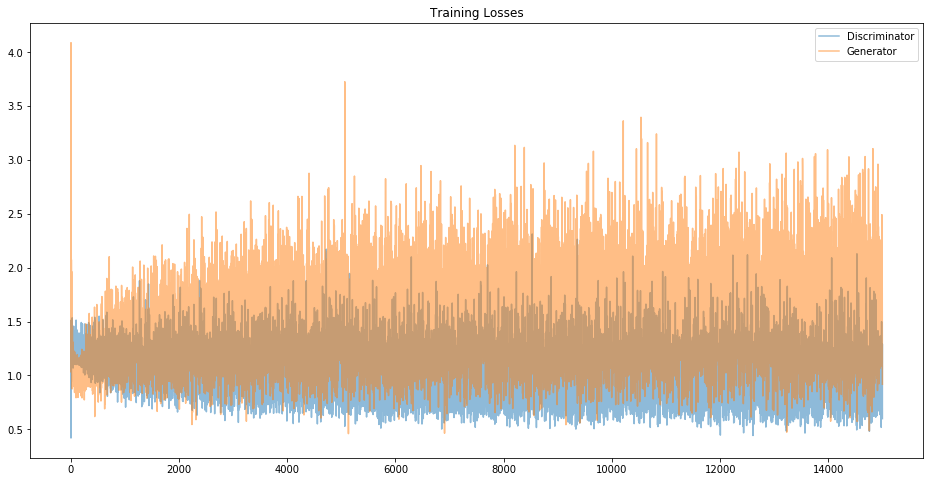

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title('Training Losses')
plt.legend()
plt.savefig('dlnd_face_generation_losses.png', dpi=600, transparent=True, bbox_inches='tight')

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
def view_samples(epoch, samples):
    """
    Helper function for viewing a list of passed in sample images
    :param epoch: The training epoch of the sample images to display
    :param samples: The sample images captured during training
    """

    fig, axes = plt.subplots(figsize=(16, 4), nrows=2, ncols=8, sharey=True, sharex=True)

    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32, 32, 3)))

In [25]:
# load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

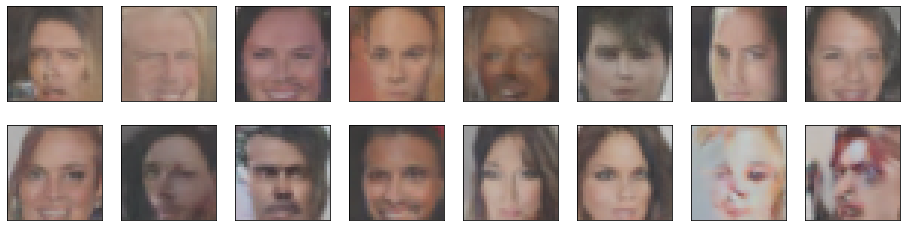

In [26]:
_ = view_samples(-1, samples)
plt.savefig('dlnd_face_generation_samples.png', dpi=600, transparent=True, bbox_inches='tight')

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

The architectures of the discriminator and generator neural networks are inspired by the DCGAN guidelines from [Radford et al 2015](http://arxiv.org/abs/1511.06434). <table align='center' width=80%><tr><td bgcolor='white'><img src='dlnd_face_generation_images/discriminator_architecture.png'></td><td bgcolor='white'><img src='dlnd_face_generation_images/generator_architecture.png'></td></tr><tr><td><p style='text-align:center'>Fig. 1 (a): Discriminator Neural Network</p></td><td><p style='text-align:center'>Fig. 1 (b): Generator Neural Network</p></td></tr></table>

The generator neural network learns successfully to produce face-looking images from random pixel values. During the training process, the generated images represent face shapes in the earlier epochs that progressively become realistic-looking with more complex facial features in later ones. <table align='center' width=80%><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_samples_2.png'></td></tr><tr><td><p style='text-align:center'>Fig. 2 (a): Fixed Samples Generated at Epoch 2</p></td></tr><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_samples_52.png'></td></tr><tr><td><p style='text-align:center'>Fig. 2 (b): Fixed Samples Generated at Epoch 52</p></td></tr><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_samples_102.png'></td></tr><tr><td><p style='text-align:center'>Fig. 2 (c): Fixed Samples Generated at Epoch 102</p></td></tr><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_samples_402.png'></td></tr><tr><td><p style='text-align:center'>Fig. 2 (d): Fixed Samples Generated at Epoch 402</p></td></tr><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_samples_802.png'></td></tr><tr><td><p style='text-align:center'>Fig. 2 (e): Fixed Samples Generated at Epoch 802</p></td></tr></table>

However, it is challenging to preserve a balanced loss relation between both neural networks during this process. In most cases, the discriminator tends to converge faster than the generator. The smoothing of the real loss (i.e., smooth=True vs. smooth=False) and the use of regularization in the discriminator (i.e., Dropout with p=0.25 vs. p=0.00) seem to delay the divergence of the generator. These modifications combined with an increase of feature maps in the convolutional layers of the generator (i.e., g_conv_dim=64 vs. g_conv_dim=32) help to overcome this challenge providing a sustainable training process. <table align='center' width=80%><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_baseline_losses.png'></td><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_smooth_losses.png'></td></tr><tr><td><p style='text-align:center'>Fig. 3 (a): Baseline</p></td><td><p style='text-align:center'>Fig. 3 (b): Baseline + Smooth</p></td></tr><tr><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_dropout_losses.png'></td><td bgcolor='white'><img src='dlnd_face_generation_images/dlnd_face_generation_map_losses.png'></td></tr><tr><td><p style='text-align:center'>Fig. 3 (c): Baseline + Smooth + Dropout</p></td><td><p style='text-align:center'>Fig. 3 (d): Baseline + Smooth + Dropout + Feature Map</p></td></tr></table>

The implemented optimization strategy can be further improved using the training algorithm introduced by [Karras et al 2017](http://arxiv.org/abs/1710.10196), which progressively grows the discriminator and generator neural networks. This approach to GAN speeds up and stabilizes the training process leading to higher quality generated images. Further improvements can also include modifications to the architecture of the generator neural network proposed by [Karras et al 2018](http://arxiv.org/abs/1812.04948).

Finally, it is worth noting that the CelebA dataset demographics published by [Rudd et al 2016](http://arxiv.org/abs/1603.07027) indicate that its images are skewed favoring some attributes over others. This bias in the data contributes to the generation of malformed and unnatural faces. Future iterations of this project could use the dataset created by [Merler et al 2019](http://arxiv.org/abs/1901.10436) instead, since it is especially designed to advance the study of fairness and accuracy in face recognition technology. <table align='center' width=100%><tr><td bgcolor='white'><img src='dlnd_face_generation_images/celeba_dataset_bias.png'></td></tr><tr><td><p style='text-align:center'>Fig. 4: Distribution  of CelebA attribute labels: (blue) presence or (tan) absence</p></td></tr></table>

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.